## Does not make sense

Cannot be finetuned with all 4 losses. The term 1 and term 4 are contradictory.

In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

C:\Users\ladwi\anaconda3\envs\deeplearning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:5')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cuda:5


In [3]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __getitem__(self, index):
        return self.X[index]
    
    def __len__(self):
        return len(self.X)

In [4]:
data_df = pd.read_csv("./../02_training/all_data_lake_modeling_in_time.csv")
time = data_df['time']
data_df = data_df.drop(columns=['time'])
data_df
display(data_df.head)

<bound method NDFrame.head of          depth  AirTemp_degC  Longwave_Wm-2  Latent_Wm-2  Sensible_Wm-2  \
0            1     -2.989824     551.514698   -19.194445     -28.116538   
1            2     -2.989824     551.514698   -19.194445     -28.116538   
2            3     -2.989824     551.514698   -19.194445     -28.116538   
3            4     -2.989824     551.514698   -19.194445     -28.116538   
4            5     -2.989824     551.514698   -19.194445     -28.116538   
...        ...           ...            ...          ...            ...   
2628545     46    -12.920028     494.226632   -46.982710     -95.220702   
2628546     47    -12.920028     494.226632   -46.982710     -95.220702   
2628547     48    -12.920028     494.226632   -46.982710     -95.220702   
2628548     49    -12.920028     494.226632   -46.982710     -95.220702   
2628549     50    -12.920028     494.226632   -46.982710     -95.220702   

         Shortwave_Wm-2  lightExtinct_m-1  ShearVelocity_mS-1  \
0   

In [5]:
training_frac = 0.60
depth_steps = 50
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 52571
Number of training points: 1577100


# Normalizing Data

In [6]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

train_time = time[:n_obs]
test_time = time[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [7]:
m0_output_column_ix = [data_df.columns.get_loc(column) for column in ['temp_heat01']]

# Loading Models

In [8]:
m0_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1','Area_m2', 
                 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice', 'temp_initial00']
m0_output_columns = ['temp_heat01']

m0_input_column_ix = [data_df.columns.get_loc(column) for column in m0_input_columns]
m0_output_column_ix = [data_df.columns.get_loc(column) for column in m0_output_columns]

m0_PATH =  f"./../02_training/saved_models/heating_model_time.pth"
m0_layers = [len(m0_input_columns), 32, 32, len(m0_output_columns)]

heating_model = MLP(m0_layers, activation="gelu")
m0_checkpoint = torch.load(m0_PATH, map_location=torch.device('cpu'))
heating_model.load_state_dict(m0_checkpoint)
heating_model = heating_model.to(device)

Initializing Network with Xavier Initialization..


## Heat Diffusion Model

In [9]:
m1_input_columns =['depth', 'Area_m2', 'Uw',
                 'buoyancy', 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice', 'diffusivity', 'temp_initial00', 'temp_heat01', 'temp_total05']
m1_output_columns = ['temp_diff02']

m1_input_column_ix = [data_df.columns.get_loc(column) for column in m1_input_columns]
m1_output_column_ix = [data_df.columns.get_loc(column) for column in m1_output_columns]

m1_PATH = f"./../02_training/saved_models/diffusion_model_time.pth"
m1_layers = [len(m1_input_columns), 32, 32, len(m1_output_columns)]

heat_diff_model = MLP(m1_layers, activation="gelu")
m1_checkpoint = torch.load(m1_PATH, map_location=torch.device('cpu'))
heat_diff_model.load_state_dict(m1_checkpoint)
heat_diff_model = heat_diff_model.to(device)

Initializing Network with Xavier Initialization..


## Mixing Model

In [10]:
m2_input_columns = ['depth', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'day_of_year', 'time_of_day',
                   'ice', 'snow', 'snowice', 'temp_diff02']
m2_output_columns = ['temp_mix03']

m2_input_column_ix = [data_df.columns.get_loc(column) for column in m2_input_columns]
m2_output_column_ix = [data_df.columns.get_loc(column) for column in m2_output_columns]

m2_PATH = f"./../02_training/saved_models/mixing_model_time.pth"
m2_layers = [len(m2_input_columns), 32, 32, len(m2_output_columns)]

mixing_model = MLP(m2_layers, activation="gelu")
m2_checkpoint = torch.load(m2_PATH, map_location=torch.device('cpu'))
mixing_model.load_state_dict(m2_checkpoint)
mixing_model = mixing_model.to(device)

Initializing Network with Xavier Initialization..


# Convection Model

In [11]:
m3_input_columns =  ['depth', 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice',  'temp_initial00', 'temp_heat01', 'temp_total05', 'temp_diff02']
m3_output_columns = ['temp_conv04']

m3_input_column_ix = [data_df.columns.get_loc(column) for column in m3_input_columns]
m3_output_column_ix = [data_df.columns.get_loc(column) for column in m3_output_columns]

m3_PATH = f"./../02_training/saved_models/convection_model_time.pth"
m3_layers = [len(m3_input_columns), 32, 32, len(m3_output_columns)]

convection_model = MLP(m3_layers, activation="gelu")
m3_checkpoint = torch.load(m3_PATH, map_location=torch.device('cpu'))
convection_model.load_state_dict(m3_checkpoint)
convection_model = convection_model.to(device)

Initializing Network with Xavier Initialization..


# Ice Model

In [12]:
m4_input_columns =['depth', 'day_of_year', 'time_of_day','ice', 'snow', 'snowice', 'temp_initial00', 'temp_heat01']
m4_output_columns = ['temp_total05']

m4_input_column_ix = [data_df.columns.get_loc(column) for column in m4_input_columns]
m4_output_column_ix = [data_df.columns.get_loc(column) for column in m4_output_columns]

m4_PATH = f"./../02_training/saved_models/ice_model_time.pth"
m4_layers = [len(m4_input_columns), 32, 32, len(m4_output_columns)]

ice_model = MLP(m4_layers, activation="gelu")
m4_checkpoint = torch.load(m4_PATH, map_location=torch.device('cpu'))
ice_model.load_state_dict(m4_checkpoint)
ice_model = ice_model.to(device)

Initializing Network with Xavier Initialization..


In [13]:
obs_temp_columns = ['obs_temp']

obs_temp_columns_ix = [data_df.columns.get_loc(column) for column in obs_temp_columns]

In [14]:
# depth_steps = 24
# train_data = np.reshape(train_data, (train_data.shape[0]//depth_steps, depth_steps, train_data.shape[1]))
# test_data = np.reshape(test_data, (test_data.shape[0]//depth_steps, depth_steps, test_data.shape[1]))

In [15]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

In [16]:
# Create data set
batch_size = 1000

#assert batch_size % 25 ==0, "Batchsize has to be multiple of 25" 

train_dataset = DataGenerator(train_data)
test_dataset = DataGenerator(test_data)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [17]:
print(train_data.shape)
print(test_data.shape)

(1577100, 45)
(1051450, 45)


In [18]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

In [19]:
def compute_metrics(model, loader, input_columns, output_columns, train_mean, train_std):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(train_mean[output_columns]).to(device)
    std = torch.tensor(train_std[output_columns]).to(device)
    
    for x in iter(loader):
        inputs, target = x[:, input_columns].to(device).float(), x[:, output_columns].to(device).float()
        pred = model(inputs)
        target = target * std + mean
        pred = pred * std + mean
        y_.append(target)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    if y_.shape[1]==2:
        rmse_temp = rmse(y_[:,1], pred_[:,1])
        l2_error_temp = l2_error(y_[:,1], pred_[:,1])
    else:
        rmse_temp = rmse(y_[:,0], pred_[:,0])
        l2_error_temp = l2_error(y_[:,0], pred_[:,0])
        
    return rmse_temp, l2_error_temp

In [20]:
def get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, loader, plot = True):    
    heating_model.eval()
    heat_diff_model.eval()
    mixing_model.eval()
    convection_model.eval()
    ice_model.eval()

    mean = torch.tensor(train_mean[m3_output_column_ix]).float().to(device)
    std = torch.tensor(train_std[m3_output_column_ix]).float().to(device)

    m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
    m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

#     depthwise_y_pred = []
#     depthwise_y_true = []
    y_ = []
    y_obs_ = []
    pred_ = []
        
    rmse_models = np.zeros((len(loader), 5))
    for ix, x in enumerate(iter(loader)):
        x = x.to(device).float()
        
        m0_input = x[:, m0_input_column_ix]
            
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
            
        if plot:
            m0_y_true = x[:, m0_output_column_ix[0]] * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
            m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 0] = rmse(m0_y_true.squeeze(), m0_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m0", rmse(m0_y_true.flatten(), m0_y_pred.flatten()))

        #model 2
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m0_pred], dim=-1)

        m4_pred = ice_model(m4_input)

        
        #print(m1_pred)
        
        if plot:
            m4_y_true = x[:, m4_output_column_ix[0]] * torch.tensor(train_std[m4_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m4_output_column_ix[0]]).to(device)
            m4_y_pred = m4_pred * torch.tensor(train_std[m4_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m4_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 1] = rmse(m4_y_true.squeeze(), m4_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m1", rmse(m4_y_true.flatten(), m4_y_pred.flatten()))


        #model 3
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m4_pred], dim=-1)
        m1_pred = heat_diff_model(m1_input)
            
        if plot:
            m1_y_true = x[:, m1_output_column_ix] * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            m1_y_pred = m1_pred * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            rmse_models[ix, 3] = rmse(m1_y_true.squeeze(), m1_y_pred.squeeze())
            print("RMSE of after m3", rmse(m1_y_true.flatten(), m1_y_pred.flatten()))

        #model 4
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m1_pred], dim=-1)
        m3_pred = convection_model(m3_input)
            
        if plot:
            m3_y_true = x[:, m3_output_column_ix] * std + mean
            m3_y_pred = m3_pred * std + mean
            rmse_models[ix, 4] = rmse(m3_y_true.squeeze(), m3_y_pred.squeeze())
            print("RMSE of after m4", rmse(m3_y_true.flatten(), m3_y_pred.flatten()))

        y_true = x[:, m3_output_column_ix] * std + mean
        y_obs = x[:, obs_temp_columns_ix] * train_std[obs_temp_columns_ix[0]] + train_mean[obs_temp_columns_ix[0]]
        pred = m3_pred * std + mean
        
        y_.append(y_true)
        y_obs_.append(y_obs)
        pred_.append(pred)

    y_ = torch.cat(y_, dim=0)
    y_obs_ = torch.cat(y_obs_, dim=0)
    pred_ = torch.cat(pred_, dim=0) 
    
    #if plot:   
     #        rmse_models = rmse_models.mean(axis=0)
     #        plt.figure(figsize=(12,8))
     #        plt.plot(rmse_models[:, 0], label="RMSE after Heating Model")
     #        plt.plot(rmse_models[:, 1], label="RMSE after Heat-Diffusion Model")
     #        plt.plot(rmse_models[:, 2], label="RMSE after Mixing Model")
     #        plt.plot(rmse_models[:, 3], label="RMSE after Convection Model")
     #        plt.plot(rmse_models[:, 4], label="RMSE after Ice Model")
     #        plt.legend(loc="upper left", fontsize=12)
     #        plt.xlabel("Depth", fontsize=12)
     #        plt.ylabel("RMSE", fontsize=12)
     #        plt.grid("on", alpha=0.5)
     #        plt.show()
    
    return pred_, y_, y_obs_, rmse_models


In [21]:
def plot_output(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='Spectral_r', vmin=0., vmax=35.)
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature")
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='Spectral_r', vmin=0., vmax=35.)
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature")
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error")
    plt.show()

# Rollout Results

## Training Results

In [22]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 0.0030799021
RMSE of after m1 0.008104489
RMSE of after m3 0.075728714
RMSE of after m4 0.07629802
RMSE of after m0 0.005100274
RMSE of after m1 0.059873275
RMSE of after m3 0.16225633
RMSE of after m4 0.16457398
RMSE of after m0 0.009541356
RMSE of after m1 0.04318201
RMSE of after m3 0.12729862
RMSE of after m4 0.12796806
RMSE of after m0 0.009100303
RMSE of after m1 0.024769811
RMSE of after m3 0.08485648
RMSE of after m4 0.08480375
RMSE of after m0 0.004205171
RMSE of after m1 0.014499267
RMSE of after m3 0.020107118
RMSE of after m4 0.020127535
RMSE of after m0 0.0039011783
RMSE of after m1 0.009346464
RMSE of after m3 0.011699255
RMSE of after m4 0.009660346
RMSE of after m0 0.0041680806
RMSE of after m1 0.008660984
RMSE of after m3 0.0119559765
RMSE of after m4 0.0108702425
RMSE of after m0 0.003965744
RMSE of after m1 0.0075163143
RMSE of after m3 0.010589561
RMSE of after m4 0.01121064
RMSE of after m0 0.0038930282
RMSE of after m1 0.008013286
RMSE of after m3

RMSE of after m3 0.023358805
RMSE of after m4 0.022691298
RMSE of after m0 0.020542692
RMSE of after m1 0.025576554
RMSE of after m3 0.17174257
RMSE of after m4 0.17096566
RMSE of after m0 0.0071214084
RMSE of after m1 0.01102103
RMSE of after m3 0.026842076
RMSE of after m4 0.024947623
RMSE of after m0 0.0090977615
RMSE of after m1 0.012426954
RMSE of after m3 0.038723957
RMSE of after m4 0.041631088
RMSE of after m0 0.008627509
RMSE of after m1 0.011998357
RMSE of after m3 0.032605104
RMSE of after m4 0.028539788
RMSE of after m0 0.007470382
RMSE of after m1 0.009478565
RMSE of after m3 0.060367275
RMSE of after m4 0.05645462
RMSE of after m0 0.00630178
RMSE of after m1 0.007933158
RMSE of after m3 0.029609336
RMSE of after m4 0.029887263
RMSE of after m0 0.005033576
RMSE of after m1 0.007570351
RMSE of after m3 0.033667106
RMSE of after m4 0.036536556
RMSE of after m0 0.004562834
RMSE of after m1 0.005804638
RMSE of after m3 0.03451176
RMSE of after m4 0.03658317
RMSE of after m0 0.

RMSE of after m1 0.0077755307
RMSE of after m3 0.033780042
RMSE of after m4 0.031052334
RMSE of after m0 0.0093362415
RMSE of after m1 0.00908878
RMSE of after m3 0.028914263
RMSE of after m4 0.030487822
RMSE of after m0 0.0065342947
RMSE of after m1 0.0063111545
RMSE of after m3 0.017053891
RMSE of after m4 0.017685179
RMSE of after m0 0.009894204
RMSE of after m1 0.010250048
RMSE of after m3 0.058674127
RMSE of after m4 0.06053016
RMSE of after m0 0.006316807
RMSE of after m1 0.0064771427
RMSE of after m3 0.030528639
RMSE of after m4 0.031535164
RMSE of after m0 0.006206361
RMSE of after m1 0.006128273
RMSE of after m3 0.026128985
RMSE of after m4 0.02171358
RMSE of after m0 0.0062169866
RMSE of after m1 0.0059193573
RMSE of after m3 0.04065968
RMSE of after m4 0.038411967
RMSE of after m0 0.011204851
RMSE of after m1 0.010806694
RMSE of after m3 0.058289427
RMSE of after m4 0.058533993
RMSE of after m0 0.0049562776
RMSE of after m1 0.005440638
RMSE of after m3 0.018500274
RMSE of af

RMSE of after m1 0.0077443267
RMSE of after m3 0.026597813
RMSE of after m4 0.021380693
RMSE of after m0 0.00665378
RMSE of after m1 0.008404534
RMSE of after m3 0.030629782
RMSE of after m4 0.025914924
RMSE of after m0 0.012104803
RMSE of after m1 0.013567942
RMSE of after m3 0.049855623
RMSE of after m4 0.04858601
RMSE of after m0 0.010374762
RMSE of after m1 0.011325034
RMSE of after m3 0.044050455
RMSE of after m4 0.043367025
RMSE of after m0 0.007213515
RMSE of after m1 0.007813705
RMSE of after m3 0.026602363
RMSE of after m4 0.02590281
RMSE of after m0 0.006926414
RMSE of after m1 0.007119528
RMSE of after m3 0.04837563
RMSE of after m4 0.047466006
RMSE of after m0 0.0070473677
RMSE of after m1 0.0073884293
RMSE of after m3 0.0268303
RMSE of after m4 0.024805255
RMSE of after m0 0.0074044066
RMSE of after m1 0.008006884
RMSE of after m3 0.033415537
RMSE of after m4 0.02940236
RMSE of after m0 0.008126869
RMSE of after m1 0.0087892
RMSE of after m3 0.03238054
RMSE of after m4 0.0

RMSE of after m0 0.005227433
RMSE of after m1 0.007861757
RMSE of after m3 0.12798129
RMSE of after m4 0.11540688
RMSE of after m0 0.0027724984
RMSE of after m1 0.007856342
RMSE of after m3 0.051263165
RMSE of after m4 0.0511623
RMSE of after m0 0.005698518
RMSE of after m1 0.015195316
RMSE of after m3 0.06803834
RMSE of after m4 0.06800368
RMSE of after m0 0.008965876
RMSE of after m1 0.01268934
RMSE of after m3 0.48387268
RMSE of after m4 0.47393608
RMSE of after m0 0.005525816
RMSE of after m1 0.008773709
RMSE of after m3 0.06043153
RMSE of after m4 0.058855467
RMSE of after m0 0.003628206
RMSE of after m1 0.00713274
RMSE of after m3 0.0828681
RMSE of after m4 0.08162622
RMSE of after m0 0.0053092185
RMSE of after m1 0.006844561
RMSE of after m3 0.07667677
RMSE of after m4 0.07589656
RMSE of after m0 0.0031615377
RMSE of after m1 0.009072787
RMSE of after m3 0.04907912
RMSE of after m4 0.046295207
RMSE of after m0 0.005634537
RMSE of after m1 0.00829084
RMSE of after m3 0.041725524


RMSE of after m1 0.004512963
RMSE of after m3 0.01396279
RMSE of after m4 0.013180462
RMSE of after m0 0.0023065729
RMSE of after m1 0.0041125244
RMSE of after m3 0.010624586
RMSE of after m4 0.010141937
RMSE of after m0 0.0020002301
RMSE of after m1 0.006556906
RMSE of after m3 0.008967141
RMSE of after m4 0.00836462
RMSE of after m0 0.0018768715
RMSE of after m1 0.006012093
RMSE of after m3 0.008625162
RMSE of after m4 0.008455341
RMSE of after m0 0.0016258352
RMSE of after m1 0.0081845615
RMSE of after m3 0.009655925
RMSE of after m4 0.00933835
RMSE of after m0 0.0022707772
RMSE of after m1 0.0048712646
RMSE of after m3 0.06212419
RMSE of after m4 0.062224973
RMSE of after m0 0.0050080023
RMSE of after m1 0.00698389
RMSE of after m3 0.045574497
RMSE of after m4 0.045452863
RMSE of after m0 0.0045310906
RMSE of after m1 0.005230668
RMSE of after m3 0.019706758
RMSE of after m4 0.019455602
RMSE of after m0 0.003472408
RMSE of after m1 0.008767307
RMSE of after m3 0.024735423
RMSE of a

RMSE of after m1 0.004328343
RMSE of after m3 0.016985226
RMSE of after m4 0.019978128
RMSE of after m0 0.004921225
RMSE of after m1 0.0075111073
RMSE of after m3 0.015734987
RMSE of after m4 0.019197477
RMSE of after m0 0.005029574
RMSE of after m1 0.007017963
RMSE of after m3 0.016447952
RMSE of after m4 0.019265601
RMSE of after m0 0.004328316
RMSE of after m1 0.0083562145
RMSE of after m3 0.022815818
RMSE of after m4 0.024582203
RMSE of after m0 0.0046293004
RMSE of after m1 0.0070161503
RMSE of after m3 0.022226527
RMSE of after m4 0.024998685
RMSE of after m0 0.0072812266
RMSE of after m1 0.00589478
RMSE of after m3 0.019900773
RMSE of after m4 0.021535678
RMSE of after m0 0.008668829
RMSE of after m1 0.0069845673
RMSE of after m3 0.018073244
RMSE of after m4 0.020219896
RMSE of after m0 0.005524609
RMSE of after m1 0.008894911
RMSE of after m3 0.0164244
RMSE of after m4 0.0199025
RMSE of after m0 0.00440908
RMSE of after m1 0.0084155705
RMSE of after m3 0.02387732
RMSE of after 

RMSE of after m1 0.016866684
RMSE of after m3 0.032429706
RMSE of after m4 0.032809474
RMSE of after m0 0.02679376
RMSE of after m1 0.027758477
RMSE of after m3 0.24626082
RMSE of after m4 0.24291986
RMSE of after m0 0.0085162325
RMSE of after m1 0.009055673
RMSE of after m3 0.0468477
RMSE of after m4 0.046615258
RMSE of after m0 0.008907548
RMSE of after m1 0.009045868
RMSE of after m3 0.03850231
RMSE of after m4 0.04199419
RMSE of after m0 0.009421452
RMSE of after m1 0.010351145
RMSE of after m3 0.052156657
RMSE of after m4 0.053854924
RMSE of after m0 0.007198611
RMSE of after m1 0.0077890824
RMSE of after m3 0.043979395
RMSE of after m4 0.038486533
RMSE of after m0 0.0064068735
RMSE of after m1 0.006782301
RMSE of after m3 0.025589634
RMSE of after m4 0.022563461
RMSE of after m0 0.004301554
RMSE of after m1 0.0049443534
RMSE of after m3 0.0147861345
RMSE of after m4 0.01505885
RMSE of after m0 0.0041345684
RMSE of after m1 0.00478041
RMSE of after m3 0.01949427
RMSE of after m4 0

RMSE of after m1 0.004660095
RMSE of after m3 0.021067202
RMSE of after m4 0.017904188
RMSE of after m0 0.004974842
RMSE of after m1 0.005455292
RMSE of after m3 0.021919398
RMSE of after m4 0.020228788
RMSE of after m0 0.005288881
RMSE of after m1 0.0055182013
RMSE of after m3 0.016874496
RMSE of after m4 0.018365623
RMSE of after m0 0.0045700725
RMSE of after m1 0.0050137984
RMSE of after m3 0.013974154
RMSE of after m4 0.015184627
RMSE of after m0 0.005468414
RMSE of after m1 0.005822794
RMSE of after m3 0.018617425
RMSE of after m4 0.018591238
RMSE of after m0 0.0037751482
RMSE of after m1 0.0042795097
RMSE of after m3 0.012091988
RMSE of after m4 0.012347154
RMSE of after m0 0.00534241
RMSE of after m1 0.0060697985
RMSE of after m3 0.014025645
RMSE of after m4 0.015881643
RMSE of after m0 0.007976846
RMSE of after m1 0.009000801
RMSE of after m3 0.03257691
RMSE of after m4 0.03335356
RMSE of after m0 0.014569579
RMSE of after m1 0.015186892
RMSE of after m3 0.053464584
RMSE of aft

RMSE of after m0 0.00518112
RMSE of after m1 0.005640471
RMSE of after m3 0.031509824
RMSE of after m4 0.024631001
RMSE of after m0 0.0049149324
RMSE of after m1 0.005642121
RMSE of after m3 0.014641278
RMSE of after m4 0.016242664
RMSE of after m0 0.0044266223
RMSE of after m1 0.005417787
RMSE of after m3 0.043773647
RMSE of after m4 0.045482703
RMSE of after m0 0.0041144188
RMSE of after m1 0.0052780267
RMSE of after m3 0.01395691
RMSE of after m4 0.01770069
RMSE of after m0 0.0071488144
RMSE of after m1 0.007824958
RMSE of after m3 0.02411771
RMSE of after m4 0.025369616
RMSE of after m0 0.004412291
RMSE of after m1 0.0057199234
RMSE of after m3 0.023562388
RMSE of after m4 0.025894854
RMSE of after m0 0.0037700336
RMSE of after m1 0.004901149
RMSE of after m3 0.020063719
RMSE of after m4 0.022548398
RMSE of after m0 0.008446439
RMSE of after m1 0.009661776
RMSE of after m3 0.09562109
RMSE of after m4 0.09747134
RMSE of after m0 0.01143506
RMSE of after m1 0.011780415
RMSE of after 

RMSE of after m1 0.028568907
RMSE of after m3 0.07707893
RMSE of after m4 0.07656895
RMSE of after m0 0.0021395138
RMSE of after m1 0.009834761
RMSE of after m3 0.031068211
RMSE of after m4 0.030501649
RMSE of after m0 0.0026232228
RMSE of after m1 0.0058066775
RMSE of after m3 0.029576596
RMSE of after m4 0.028959693
RMSE of after m0 0.0033039914
RMSE of after m1 0.005216741
RMSE of after m3 0.024067037
RMSE of after m4 0.023351083
RMSE of after m0 0.00393869
RMSE of after m1 0.00509282
RMSE of after m3 0.017771615
RMSE of after m4 0.016869245
RMSE of after m0 0.0035028588
RMSE of after m1 0.0072461236
RMSE of after m3 0.021191245
RMSE of after m4 0.020963326
RMSE of after m0 0.008291742
RMSE of after m1 0.010665895
RMSE of after m3 0.020364676
RMSE of after m4 0.01990682
RMSE of after m0 0.0059339274
RMSE of after m1 0.009010795
RMSE of after m3 0.016591378
RMSE of after m4 0.016796444
RMSE of after m0 0.0064484864
RMSE of after m1 0.007090678
RMSE of after m3 0.013843873
RMSE of aft

RMSE of after m1 0.0047397264
RMSE of after m3 0.023471883
RMSE of after m4 0.027072998
RMSE of after m0 0.004736699
RMSE of after m1 0.005367159
RMSE of after m3 0.013865663
RMSE of after m4 0.017230008
RMSE of after m0 0.006358638
RMSE of after m1 0.005866608
RMSE of after m3 0.014337431
RMSE of after m4 0.017793788
RMSE of after m0 0.005958503
RMSE of after m1 0.0072090407
RMSE of after m3 0.014927053
RMSE of after m4 0.018864991
RMSE of after m0 0.0050521754
RMSE of after m1 0.0052173627
RMSE of after m3 0.015700504
RMSE of after m4 0.019102998
RMSE of after m0 0.0033805864
RMSE of after m1 0.004800534
RMSE of after m3 0.014175073
RMSE of after m4 0.017534774
RMSE of after m0 0.006356705
RMSE of after m1 0.0062633054
RMSE of after m3 0.015153249
RMSE of after m4 0.018989887
RMSE of after m0 0.0062722545
RMSE of after m1 0.007489426
RMSE of after m3 0.013804405
RMSE of after m4 0.017713418
RMSE of after m0 0.006017802
RMSE of after m1 0.007880066
RMSE of after m3 0.0374476
RMSE of a

RMSE of after m4 0.014957874
RMSE of after m0 0.004737586
RMSE of after m1 0.009094661
RMSE of after m3 0.014519135
RMSE of after m4 0.01609013
RMSE of after m0 0.0049248915
RMSE of after m1 0.008244889
RMSE of after m3 0.013503405
RMSE of after m4 0.016904805
RMSE of after m0 0.0072998735
RMSE of after m1 0.008676084
RMSE of after m3 0.01084244
RMSE of after m4 0.013259656
RMSE of after m0 0.006393327
RMSE of after m1 0.010418557
RMSE of after m3 0.017096946
RMSE of after m4 0.018874984
RMSE of after m0 0.007366216
RMSE of after m1 0.010630939
RMSE of after m3 0.012660689
RMSE of after m4 0.014116877
RMSE of after m0 0.008725995
RMSE of after m1 0.011161389
RMSE of after m3 0.015170994
RMSE of after m4 0.016113045
RMSE of after m0 0.009934
RMSE of after m1 0.008388913
RMSE of after m3 0.023767283
RMSE of after m4 0.0249125
RMSE of after m0 0.006483407
RMSE of after m1 0.007754391
RMSE of after m3 0.015532381
RMSE of after m4 0.017198753
RMSE of after m0 0.008395531
RMSE of after m1 0.

RMSE of after m4 0.015863147
RMSE of after m0 0.0069734594
RMSE of after m1 0.007454854
RMSE of after m3 0.04798326
RMSE of after m4 0.046105962
RMSE of after m0 0.004019265
RMSE of after m1 0.0049073156
RMSE of after m3 0.015327662
RMSE of after m4 0.016259082
RMSE of after m0 0.005821072
RMSE of after m1 0.0065288846
RMSE of after m3 0.015039426
RMSE of after m4 0.017147696
RMSE of after m0 0.004855912
RMSE of after m1 0.0057116826
RMSE of after m3 0.04088705
RMSE of after m4 0.04191981
RMSE of after m0 0.005493299
RMSE of after m1 0.0060587926
RMSE of after m3 0.030842554
RMSE of after m4 0.03273535
RMSE of after m0 0.005017962
RMSE of after m1 0.005627247
RMSE of after m3 0.018806897
RMSE of after m4 0.016491516
RMSE of after m0 0.0037269075
RMSE of after m1 0.004520367
RMSE of after m3 0.0119780665
RMSE of after m4 0.013800292
RMSE of after m0 0.0039336383
RMSE of after m1 0.0049164956
RMSE of after m3 0.010480036
RMSE of after m4 0.012649484
RMSE of after m0 0.005692798
RMSE of a

RMSE of after m3 0.026334079
RMSE of after m4 0.027154656
RMSE of after m0 0.0074709975
RMSE of after m1 0.007881465
RMSE of after m3 0.028951708
RMSE of after m4 0.030715495
RMSE of after m0 0.008943836
RMSE of after m1 0.009759316
RMSE of after m3 0.02999229
RMSE of after m4 0.031352874
RMSE of after m0 0.0072151264
RMSE of after m1 0.007999671
RMSE of after m3 0.028190827
RMSE of after m4 0.02448562
RMSE of after m0 0.0045960345
RMSE of after m1 0.005463018
RMSE of after m3 0.033605445
RMSE of after m4 0.026922612
RMSE of after m0 0.0064544207
RMSE of after m1 0.006893347
RMSE of after m3 0.044814657
RMSE of after m4 0.045967452
RMSE of after m0 0.004612251
RMSE of after m1 0.0054962765
RMSE of after m3 0.014039919
RMSE of after m4 0.01567035
RMSE of after m0 0.0039881496
RMSE of after m1 0.0046975072
RMSE of after m3 0.016037613
RMSE of after m4 0.01696049
RMSE of after m0 0.0054769604
RMSE of after m1 0.006334103
RMSE of after m3 0.03548954
RMSE of after m4 0.03646878
RMSE of afte

RMSE of after m3 0.037774447
RMSE of after m4 0.031342477
RMSE of after m0 0.0053964024
RMSE of after m1 0.005852717
RMSE of after m3 0.052813306
RMSE of after m4 0.043368913
RMSE of after m0 0.0066886116
RMSE of after m1 0.007060475
RMSE of after m3 0.029925462
RMSE of after m4 0.03324681
RMSE of after m0 0.0068214033
RMSE of after m1 0.0076226634
RMSE of after m3 0.05254718
RMSE of after m4 0.044528693
RMSE of after m0 0.0044808206
RMSE of after m1 0.0053760605
RMSE of after m3 0.028439887
RMSE of after m4 0.026926404
RMSE of after m0 0.003909385
RMSE of after m1 0.005168943
RMSE of after m3 0.023183776
RMSE of after m4 0.020469481
RMSE of after m0 0.0060676206
RMSE of after m1 0.008088383
RMSE of after m3 0.18094203
RMSE of after m4 0.18289644
RMSE of after m0 0.0044264807
RMSE of after m1 0.014975743
RMSE of after m3 0.13217169
RMSE of after m4 0.1308452
RMSE of after m0 0.004137185
RMSE of after m1 0.063325845
RMSE of after m3 0.071056485
RMSE of after m4 0.072222516
RMSE of after

RMSE of after m1 0.0055404883
RMSE of after m3 0.0075108497
RMSE of after m4 0.0076002316
RMSE of after m0 0.003432522
RMSE of after m1 0.0038440474
RMSE of after m3 0.009364207
RMSE of after m4 0.009605611
RMSE of after m0 0.006308503
RMSE of after m1 0.0062575797
RMSE of after m3 0.012955004
RMSE of after m4 0.012447223
RMSE of after m0 0.008666165
RMSE of after m1 0.005623298
RMSE of after m3 0.014510432
RMSE of after m4 0.013709849
RMSE of after m0 0.00990364
RMSE of after m1 0.006409538
RMSE of after m3 0.028290907
RMSE of after m4 0.029121041
RMSE of after m0 0.0048578745
RMSE of after m1 0.0060100234
RMSE of after m3 0.012055918
RMSE of after m4 0.014578339
RMSE of after m0 0.003144407
RMSE of after m1 0.0078019802
RMSE of after m3 0.018090487
RMSE of after m4 0.019272277
RMSE of after m0 0.0033203836
RMSE of after m1 0.004867175
RMSE of after m3 0.010649686
RMSE of after m4 0.013558788
RMSE of after m0 0.0050371736
RMSE of after m1 0.006307548
RMSE of after m3 0.022761341
RMSE 

RMSE of after m4 0.03707831
RMSE of after m0 0.00492393
RMSE of after m1 0.011600553
RMSE of after m3 0.018086625
RMSE of after m4 0.021569313
RMSE of after m0 0.004830579
RMSE of after m1 0.009963527
RMSE of after m3 0.014845916
RMSE of after m4 0.017960748
RMSE of after m0 0.005332611
RMSE of after m1 0.008224123
RMSE of after m3 0.037609734
RMSE of after m4 0.039215706
RMSE of after m0 0.007012066
RMSE of after m1 0.009727706
RMSE of after m3 0.016892819
RMSE of after m4 0.021009017
RMSE of after m0 0.0069705388
RMSE of after m1 0.008067318
RMSE of after m3 0.02080238
RMSE of after m4 0.02505146
RMSE of after m0 0.0050137537
RMSE of after m1 0.011229304
RMSE of after m3 0.01630628
RMSE of after m4 0.020134537
RMSE of after m0 0.0035833346
RMSE of after m1 0.005607059
RMSE of after m3 0.01511235
RMSE of after m4 0.01923833
RMSE of after m0 0.0038331891
RMSE of after m1 0.0060377913
RMSE of after m3 0.01425518
RMSE of after m4 0.0175368
RMSE of after m0 0.0048829373
RMSE of after m1 0

RMSE of after m4 0.018217603
RMSE of after m0 0.0044770325
RMSE of after m1 0.0037984324
RMSE of after m3 0.023749659
RMSE of after m4 0.025251595
RMSE of after m0 0.0053254184
RMSE of after m1 0.005279141
RMSE of after m3 0.017409256
RMSE of after m4 0.018222462
RMSE of after m0 0.0043420135
RMSE of after m1 0.0047789267
RMSE of after m3 0.023200637
RMSE of after m4 0.023160689
RMSE of after m0 0.015046514
RMSE of after m1 0.015300994
RMSE of after m3 0.09301191
RMSE of after m4 0.09169439
RMSE of after m0 0.009981403
RMSE of after m1 0.010027913
RMSE of after m3 0.053393394
RMSE of after m4 0.044795357
RMSE of after m0 0.0074119004
RMSE of after m1 0.0076163723
RMSE of after m3 0.03292016
RMSE of after m4 0.024929864
RMSE of after m0 0.0059235003
RMSE of after m1 0.006230878
RMSE of after m3 0.025657898
RMSE of after m4 0.020578116
RMSE of after m0 0.0066526965
RMSE of after m1 0.0070893117
RMSE of after m3 0.029549487
RMSE of after m4 0.030224014
RMSE of after m0 0.006584834
RMSE of

The RMSEs after each modelling stage: [0.00582412 0.00751775 0.         0.03021206 0.03017742]


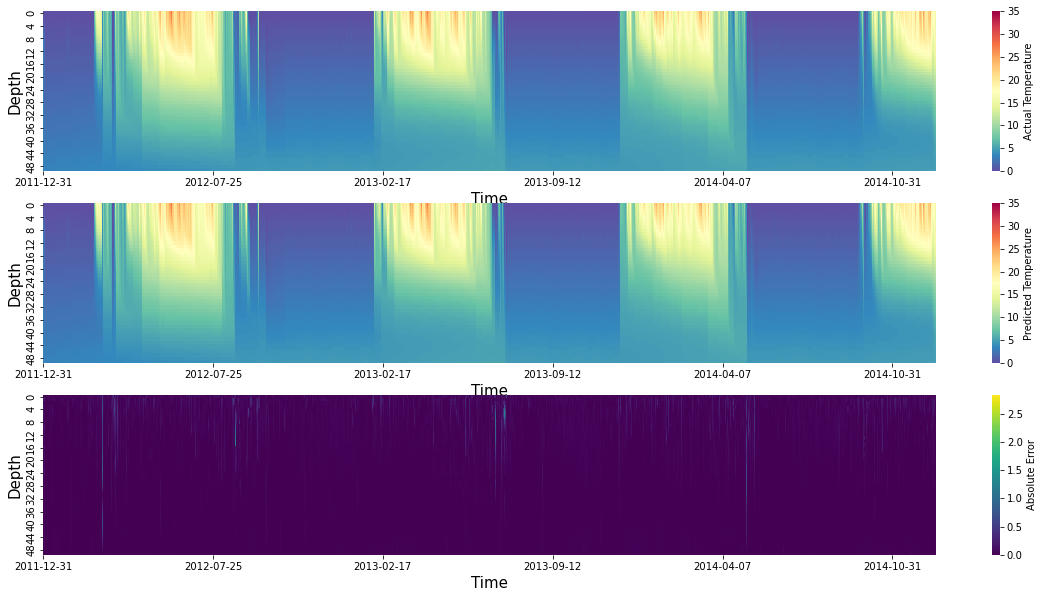

In [23]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

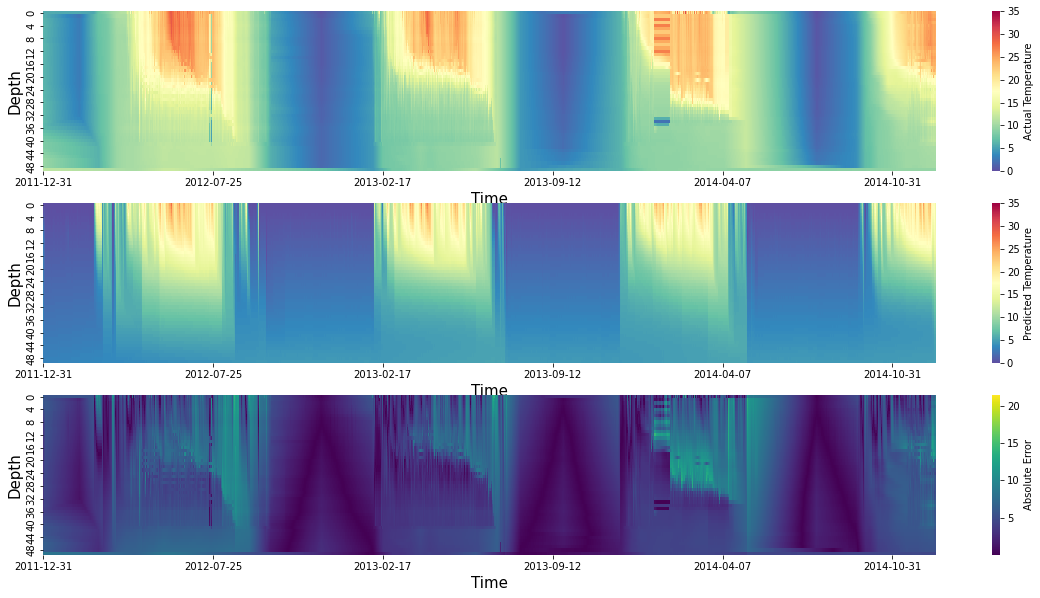

In [24]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

## Test Results

In [25]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model,heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.0035381785
RMSE of after m1 0.004089798
RMSE of after m3 0.019096078
RMSE of after m4 0.015534168
RMSE of after m0 0.005730843
RMSE of after m1 0.0061053326
RMSE of after m3 0.021925136
RMSE of after m4 0.022082191
RMSE of after m0 0.0054727774
RMSE of after m1 0.0059588305
RMSE of after m3 0.014535531
RMSE of after m4 0.016423704
RMSE of after m0 0.005438608
RMSE of after m1 0.0060272017
RMSE of after m3 0.010597355
RMSE of after m4 0.012850382
RMSE of after m0 0.004458562
RMSE of after m1 0.005161021
RMSE of after m3 0.012485929
RMSE of after m4 0.0151595315
RMSE of after m0 0.0053281644
RMSE of after m1 0.006173695
RMSE of after m3 0.022190174
RMSE of after m4 0.024653876
RMSE of after m0 0.0057812664
RMSE of after m1 0.006340427
RMSE of after m3 0.034913585
RMSE of after m4 0.03640966
RMSE of after m0 0.006371951
RMSE of after m1 0.006839065
RMSE of after m3 0.022597713
RMSE of after m4 0.021082366
RMSE of after m0 0.0048214174
RMSE of after m1 0.005386999
RMSE o

RMSE of after m4 0.022407776
RMSE of after m0 0.0046965615
RMSE of after m1 0.0062368084
RMSE of after m3 0.051537596
RMSE of after m4 0.045729645
RMSE of after m0 0.0046418663
RMSE of after m1 0.005761413
RMSE of after m3 0.046012927
RMSE of after m4 0.036744636
RMSE of after m0 0.010152726
RMSE of after m1 0.010905536
RMSE of after m3 0.07948625
RMSE of after m4 0.08165949
RMSE of after m0 0.0043081986
RMSE of after m1 0.008124846
RMSE of after m3 0.07424152
RMSE of after m4 0.0728395
RMSE of after m0 0.002749876
RMSE of after m1 0.008039233
RMSE of after m3 0.03451739
RMSE of after m4 0.033044957
RMSE of after m0 0.005723516
RMSE of after m1 0.009261785
RMSE of after m3 0.044234574
RMSE of after m4 0.04111612
RMSE of after m0 0.004562446
RMSE of after m1 0.0068513164
RMSE of after m3 0.08285098
RMSE of after m4 0.06612655
RMSE of after m0 0.0035439916
RMSE of after m1 0.0057518445
RMSE of after m3 0.026737178
RMSE of after m4 0.021904618
RMSE of after m0 0.005952698
RMSE of after m1

RMSE of after m1 0.020934515
RMSE of after m3 0.025182385
RMSE of after m4 0.031300165
RMSE of after m0 0.0022309322
RMSE of after m1 0.019489322
RMSE of after m3 0.03327622
RMSE of after m4 0.040090498
RMSE of after m0 0.0031312339
RMSE of after m1 0.021727659
RMSE of after m3 0.08953123
RMSE of after m4 0.09884901
RMSE of after m0 0.0075285095
RMSE of after m1 0.019929567
RMSE of after m3 0.08471861
RMSE of after m4 0.09452731
RMSE of after m0 0.010710261
RMSE of after m1 0.017999241
RMSE of after m3 0.112728134
RMSE of after m4 0.12419822
RMSE of after m0 0.009232436
RMSE of after m1 0.017956072
RMSE of after m3 0.052322373
RMSE of after m4 0.061676502
RMSE of after m0 0.0072052446
RMSE of after m1 0.017229619
RMSE of after m3 0.025849918
RMSE of after m4 0.030548085
RMSE of after m0 0.005135043
RMSE of after m1 0.017033225
RMSE of after m3 0.028894622
RMSE of after m4 0.029836588
RMSE of after m0 0.0047073234
RMSE of after m1 0.018491944
RMSE of after m3 0.03676866
RMSE of after m4

RMSE of after m0 0.0028566802
RMSE of after m1 0.014477896
RMSE of after m3 0.04288732
RMSE of after m4 0.041595656
RMSE of after m0 0.0049670204
RMSE of after m1 0.017969137
RMSE of after m3 0.11458356
RMSE of after m4 0.11201303
RMSE of after m0 0.005841311
RMSE of after m1 0.013069705
RMSE of after m3 0.059090663
RMSE of after m4 0.057787985
RMSE of after m0 0.0045006624
RMSE of after m1 0.014122182
RMSE of after m3 0.10227703
RMSE of after m4 0.10269615
RMSE of after m0 0.003317423
RMSE of after m1 0.012458742
RMSE of after m3 0.10320601
RMSE of after m4 0.10240061
RMSE of after m0 0.0035777492
RMSE of after m1 0.015114366
RMSE of after m3 0.11512285
RMSE of after m4 0.112837575
RMSE of after m0 0.0036517412
RMSE of after m1 0.020728935
RMSE of after m3 0.095211074
RMSE of after m4 0.0952899
RMSE of after m0 0.009131581
RMSE of after m1 0.013117845
RMSE of after m3 0.093379274
RMSE of after m4 0.09376924
RMSE of after m0 0.0045993193
RMSE of after m1 0.014940847
RMSE of after m3 0.

RMSE of after m1 0.0079019405
RMSE of after m3 0.034297146
RMSE of after m4 0.03555526
RMSE of after m0 0.007875996
RMSE of after m1 0.00843919
RMSE of after m3 0.04367365
RMSE of after m4 0.0455893
RMSE of after m0 0.005766871
RMSE of after m1 0.0065855733
RMSE of after m3 0.017316656
RMSE of after m4 0.02046228
RMSE of after m0 0.0058401353
RMSE of after m1 0.0066978144
RMSE of after m3 0.029757727
RMSE of after m4 0.030667713
RMSE of after m0 0.0048587266
RMSE of after m1 0.0056300587
RMSE of after m3 0.021478567
RMSE of after m4 0.01847691
RMSE of after m0 0.005616155
RMSE of after m1 0.0059162793
RMSE of after m3 0.03150389
RMSE of after m4 0.029989358
RMSE of after m0 0.0063374
RMSE of after m1 0.006886231
RMSE of after m3 0.01621369
RMSE of after m4 0.020194108
RMSE of after m0 0.004417638
RMSE of after m1 0.005094865
RMSE of after m3 0.017729864
RMSE of after m4 0.017880578
RMSE of after m0 0.005372628
RMSE of after m1 0.0060284617
RMSE of after m3 0.023471592
RMSE of after m4 

RMSE of after m1 0.006067457
RMSE of after m3 0.029362584
RMSE of after m4 0.023329249
RMSE of after m0 0.005110913
RMSE of after m1 0.005896476
RMSE of after m3 0.021381652
RMSE of after m4 0.022689397
RMSE of after m0 0.0061712423
RMSE of after m1 0.0070128813
RMSE of after m3 0.021859817
RMSE of after m4 0.025333432
RMSE of after m0 0.005025328
RMSE of after m1 0.0066088107
RMSE of after m3 0.035816282
RMSE of after m4 0.035861563
RMSE of after m0 0.005290521
RMSE of after m1 0.0065626996
RMSE of after m3 0.029959468
RMSE of after m4 0.0267187
RMSE of after m0 0.0069068745
RMSE of after m1 0.0074233017
RMSE of after m3 0.04394526
RMSE of after m4 0.033711944
RMSE of after m0 0.0040644067
RMSE of after m1 0.0054758205
RMSE of after m3 0.023359159
RMSE of after m4 0.02396968
RMSE of after m0 0.0052186702
RMSE of after m1 0.0065250043
RMSE of after m3 0.034545388
RMSE of after m4 0.029366566
RMSE of after m0 0.007778277
RMSE of after m1 0.008502832
RMSE of after m3 0.027170256
RMSE of 

RMSE of after m1 0.007344364
RMSE of after m3 0.011388153
RMSE of after m4 0.010292706
RMSE of after m0 0.002576539
RMSE of after m1 0.0067063407
RMSE of after m3 0.0069888537
RMSE of after m4 0.006117857
RMSE of after m0 0.003257909
RMSE of after m1 0.0058724103
RMSE of after m3 0.00886125
RMSE of after m4 0.0075193415
RMSE of after m0 0.0035919638
RMSE of after m1 0.007719382
RMSE of after m3 0.020557107
RMSE of after m4 0.019759731
RMSE of after m0 0.0048373323
RMSE of after m1 0.0075182784
RMSE of after m3 0.016681623
RMSE of after m4 0.015764143
RMSE of after m0 0.011216106
RMSE of after m1 0.0064761457
RMSE of after m3 0.03380189
RMSE of after m4 0.0328681
RMSE of after m0 0.010296883
RMSE of after m1 0.0065469695
RMSE of after m3 0.012636009
RMSE of after m4 0.0124721145
RMSE of after m0 0.0044259867
RMSE of after m1 0.0057821907
RMSE of after m3 0.012052542
RMSE of after m4 0.011954963
RMSE of after m0 0.0032405842
RMSE of after m1 0.0041268934
RMSE of after m3 0.011733103
RMSE

RMSE of after m3 0.02028834
RMSE of after m4 0.024347221
RMSE of after m0 0.0041434914
RMSE of after m1 0.00788436
RMSE of after m3 0.01679684
RMSE of after m4 0.022361482
RMSE of after m0 0.0062972507
RMSE of after m1 0.009270673
RMSE of after m3 0.022435846
RMSE of after m4 0.028431153
RMSE of after m0 0.006502817
RMSE of after m1 0.01130365
RMSE of after m3 0.019456126
RMSE of after m4 0.024865676
RMSE of after m0 0.00665376
RMSE of after m1 0.012164827
RMSE of after m3 0.023237742
RMSE of after m4 0.02737064
RMSE of after m0 0.018387899
RMSE of after m1 0.010827788
RMSE of after m3 0.039662693
RMSE of after m4 0.045935266
RMSE of after m0 0.011508333
RMSE of after m1 0.015603481
RMSE of after m3 0.028715845
RMSE of after m4 0.033727862
RMSE of after m0 0.0100970445
RMSE of after m1 0.015421951
RMSE of after m3 0.034336336
RMSE of after m4 0.040864617
RMSE of after m0 0.01553181
RMSE of after m1 0.020362556
RMSE of after m3 0.06428839
RMSE of after m4 0.07311939
RMSE of after m0 0.0

RMSE of after m1 0.006417065
RMSE of after m3 0.031692147
RMSE of after m4 0.02951646
RMSE of after m0 0.006032879
RMSE of after m1 0.006652478
RMSE of after m3 0.028659165
RMSE of after m4 0.024902007
RMSE of after m0 0.00422639
RMSE of after m1 0.0049882266
RMSE of after m3 0.019129489
RMSE of after m4 0.017906819
RMSE of after m0 0.0039490666
RMSE of after m1 0.0044861115
RMSE of after m3 0.01654909
RMSE of after m4 0.014758715
RMSE of after m0 0.0052305567
RMSE of after m1 0.0058818404
RMSE of after m3 0.013103772
RMSE of after m4 0.013473127
RMSE of after m0 0.0042748554
RMSE of after m1 0.0049740872
RMSE of after m3 0.01468337
RMSE of after m4 0.016356256
RMSE of after m0 0.004261631
RMSE of after m1 0.004900745
RMSE of after m3 0.020269377
RMSE of after m4 0.020094665
RMSE of after m0 0.0053223143
RMSE of after m1 0.0058984603
RMSE of after m3 0.036666654
RMSE of after m4 0.036427237
RMSE of after m0 0.0043333527
RMSE of after m1 0.0051044
RMSE of after m3 0.018078482
RMSE of af

RMSE of after m4 0.020717183
RMSE of after m0 0.010602218
RMSE of after m1 0.01137206
RMSE of after m3 0.035021406
RMSE of after m4 0.03488697
RMSE of after m0 0.010528182
RMSE of after m1 0.011703004
RMSE of after m3 0.04060931
RMSE of after m4 0.035371184
RMSE of after m0 0.008543723
RMSE of after m1 0.009322047
RMSE of after m3 0.03992043
RMSE of after m4 0.03474557
RMSE of after m0 0.0068504284
RMSE of after m1 0.0071531595
RMSE of after m3 0.039105467
RMSE of after m4 0.034023874
RMSE of after m0 0.00435871
RMSE of after m1 0.0050976463
RMSE of after m3 0.013025174
RMSE of after m4 0.014920379
RMSE of after m0 0.0079881875
RMSE of after m1 0.008789241
RMSE of after m3 0.025189964
RMSE of after m4 0.026136495
RMSE of after m0 0.0067246584
RMSE of after m1 0.0077509196
RMSE of after m3 0.024624221
RMSE of after m4 0.02322644
RMSE of after m0 0.0051566614
RMSE of after m1 0.0063023525
RMSE of after m3 0.017401155
RMSE of after m4 0.01966297
RMSE of after m0 0.0053616585
RMSE of after

RMSE of after m3 0.043646112
RMSE of after m4 0.05003544
RMSE of after m0 0.006947613
RMSE of after m1 0.0075802957
RMSE of after m3 0.051133465
RMSE of after m4 0.0511165
RMSE of after m0 0.00984512
RMSE of after m1 0.010026896
RMSE of after m3 0.03977936
RMSE of after m4 0.03419562
RMSE of after m0 0.0048321183
RMSE of after m1 0.0050642504
RMSE of after m3 0.030655995
RMSE of after m4 0.025459517
RMSE of after m0 0.0056450856
RMSE of after m1 0.005876972
RMSE of after m3 0.030022694
RMSE of after m4 0.027253732
RMSE of after m0 0.0063871834
RMSE of after m1 0.0067821434
RMSE of after m3 0.028281976
RMSE of after m4 0.030386264
RMSE of after m0 0.005462408
RMSE of after m1 0.005602658
RMSE of after m3 0.03428138
RMSE of after m4 0.03388849
RMSE of after m0 0.004706582
RMSE of after m1 0.004850552
RMSE of after m3 0.028227381
RMSE of after m4 0.021886623
RMSE of after m0 0.0072950227
RMSE of after m1 0.0072028665
RMSE of after m3 0.034840636
RMSE of after m4 0.024415048
RMSE of after 

RMSE of after m4 0.09317181
RMSE of after m0 0.004348988
RMSE of after m1 0.022852326
RMSE of after m3 0.05383895
RMSE of after m4 0.049366992
RMSE of after m0 0.0036532246
RMSE of after m1 0.02480342
RMSE of after m3 0.06908489
RMSE of after m4 0.061461534
RMSE of after m0 0.0037768476
RMSE of after m1 0.025537698
RMSE of after m3 0.032632828
RMSE of after m4 0.029308427
RMSE of after m0 0.003922971
RMSE of after m1 0.027348114
RMSE of after m3 0.054756965
RMSE of after m4 0.04890393
RMSE of after m0 0.0044834567
RMSE of after m1 0.02857809
RMSE of after m3 0.036889147
RMSE of after m4 0.032132756
RMSE of after m0 0.004414827
RMSE of after m1 0.030604543
RMSE of after m3 0.023823574
RMSE of after m4 0.020921992
RMSE of after m0 0.0056102118
RMSE of after m1 0.03181738
RMSE of after m3 0.04029354
RMSE of after m4 0.03651038
RMSE of after m0 0.0056247856
RMSE of after m1 0.030633787
RMSE of after m3 0.05903971
RMSE of after m4 0.053030107
RMSE of after m0 0.0061133043
RMSE of after m1 0

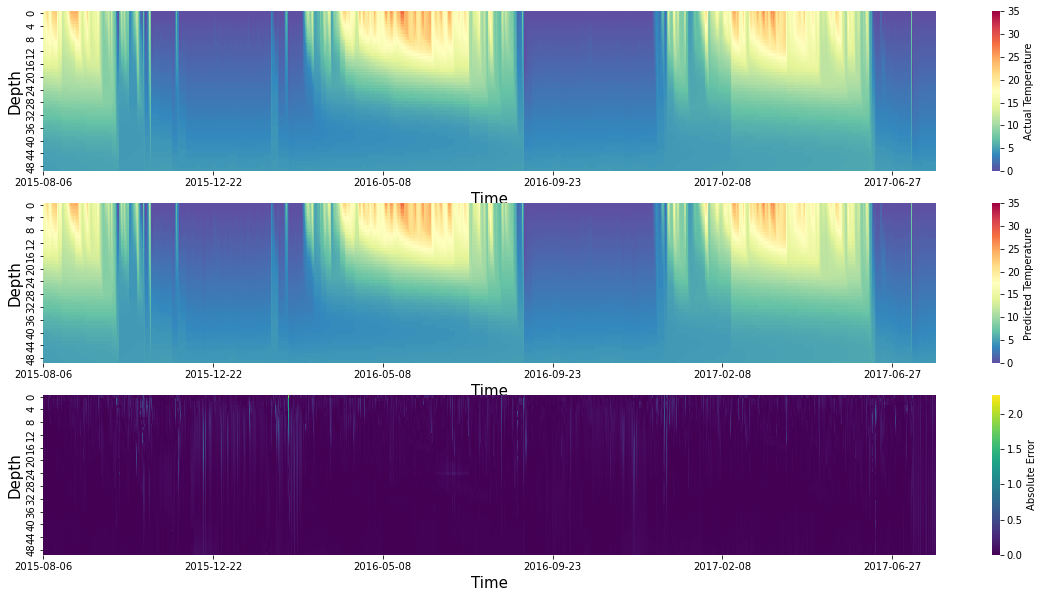

In [26]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

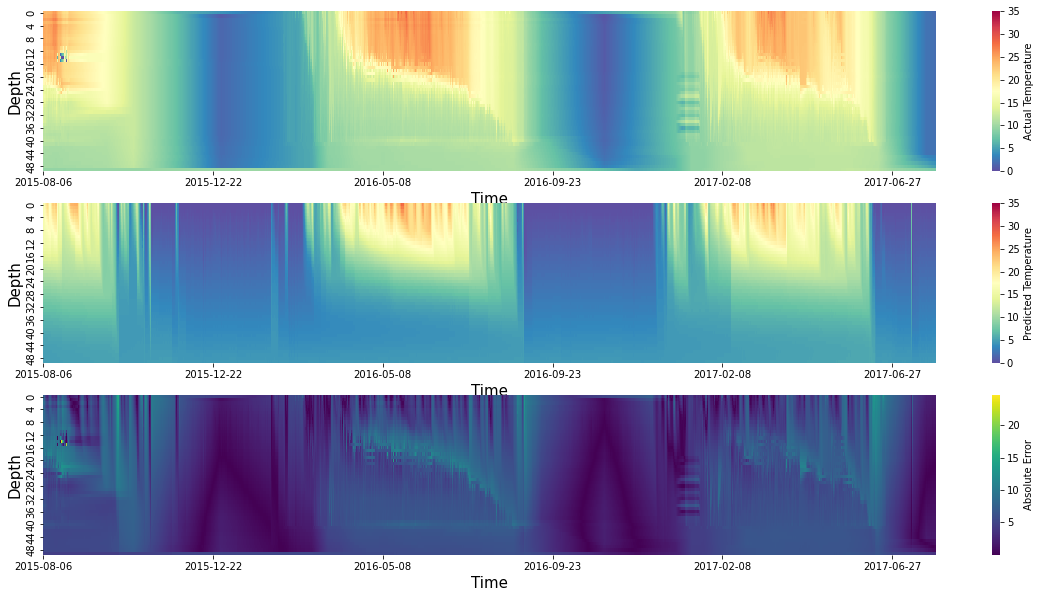

In [27]:
plot_output(test_y_pred, test_y_obs, depth_steps, test_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [28]:
train_rmse, train_l2_err = compute_metrics( heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.04330690883511116, Train L2 Error: 0.005702852971615242
Test RMSE: 0.05935795797689467, Train L2 Error: 0.007462159681301928


## Mixing Model

## Convection Model

In [29]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.014263324256871199, Train L2 Error: 0.001878372952570443
Test RMSE: 0.01547490462565185, Train L2 Error: 0.0019455367720686944


## Ice Model

In [30]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.0072898170040892425, Train L2 Error: 0.0009593164967734637
Test RMSE: 0.013696382045054916, Train L2 Error: 0.0017206306135897217


# Finetuning

In [31]:
lr = 1e-5
# decay_rate = 0.1
# decay_steps = 500

params = list(heating_model.parameters()) + list(heat_diff_model.parameters()) + list(convection_model.parameters()) + list(ice_model.parameters())

optimizer = torch.optim.Adam(params, lr=lr, 
                             betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

# Freeze model weights

In [32]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [33]:
#freeze_model(heating_model)
freeze_model(heating_model)
unfreeze_model(heat_diff_model)
freeze_model(convection_model)
freeze_model(ice_model)


# Finetuning on Observed Temperature

In [34]:
heating_model.train()
heat_diff_model.train()
convection_model.train()
ice_model.train()

n_epochs = 1000

# mean and standard dev of "temp_total04" of model 4 output
mean_out3 = torch.tensor(train_mean[m3_output_column_ix[0]]).float().to(device)
std_out3 = torch.tensor(train_std[m3_output_column_ix[0]]).float().to(device)

mean_obs = torch.tensor(train_mean[obs_temp_columns_ix[0]]).float().to(device)
std_obs = torch.tensor(train_std[obs_temp_columns_ix[0]]).float().to(device)

# mean and standard dev of "input_temp" of model 1 input
m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

train_loss = []
LOSS_m0 = []
LOSS_m1 = []
LOSS_m2 = []
LOSS_m3 = []
LOSS_m4 = []

for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    loss_epoch_m0 = 0
    loss_epoch_m1 = 0
    loss_epoch_m2 = 0
    loss_epoch_m3 = 0
    loss_epoch_m4 = 0
    for ix, x in enumerate(iter(train_loader)):
        x = x.to(device).float()
        optimizer.zero_grad()
        
      #  m1_input = x[:, m1_input_column_ix]
        m0_input = x[:, m0_input_column_ix]
        
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
        loss_m0 = criterion(m0_pred, x[:, m0_output_column_ix])

        #model 1
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m0_pred], dim=-1)
        # m1_pred = heat_diff_model(m1_input)
        
        m4_pred = ice_model(m4_input)
        loss_m4 = criterion(m4_pred, x[:, m4_output_column_ix])
        
        #m1_pred = heat_diff_model(m1_input) #predicts diff and temp
        #m1_pred_temp = m1_pred[:,1:2]
            
        #loss_m1 = criterion(m1_pred_temp, x[:, m1_output_column_ix[1]].unsqueeze(1))

        #model 3
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m4_pred], dim=-1)
        m1_pred = heat_diff_model(m1_input)

        loss_m1 = criterion(m1_pred, x[:, m1_output_column_ix])

        #model 4
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m1_pred], dim=-1)
        m3_pred = convection_model(m3_input)
        
        obs_temp_true = x[:, obs_temp_columns_ix] * std_obs + mean_obs
        obs_temp_true_norm = (obs_temp_true - mean_out3)/std_out3
        
        loss_m3 = criterion(m3_pred, obs_temp_true_norm)

        #loss = (loss_m0 + loss_m1 + loss_m2 + loss_m3 + loss_m4)
        
        loss = loss_m3
        
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss.item()
        loss_epoch_m0 += loss_m0.item()
        loss_epoch_m1 += loss_m1.item()
        loss_epoch_m3 += loss_m3.item()
        loss_epoch_m4 += loss_m4.item()
    
    loss_epoch = loss_epoch/len(train_loader)
    loss_epoch_m0 = loss_epoch_m0/len(train_loader)
    loss_epoch_m1 = loss_epoch_m1/len(train_loader)
    loss_epoch_m3 = loss_epoch_m3/len(train_loader)
    loss_epoch_m4 = loss_epoch_m4/len(train_loader)
    
    train_loss.append(loss_epoch)
    LOSS_m0.append(loss_epoch_m0)
    LOSS_m1.append(loss_epoch_m1)
    LOSS_m3.append(loss_epoch_m3)
    LOSS_m4.append(loss_epoch_m4)
    if it % 50 == 0:
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Loss m0: {LOSS_m0[-1]}, Loss m1: {LOSS_m1[-1]},  Loss m3: {LOSS_m3[-1]}, Loss m4: {LOSS_m4[-1]}")
    
    #plot the loss_m1, m2


  0%|          | 1/1000 [00:07<1:58:19,  7.11s/it]

Epoch : 0, Train_loss: 0.8140850970049416, Loss m0: 1.733708878153785e-06, Loss m1: 0.013260100509430769,  Loss m3: 0.8140850970049416, Loss m4: 3.269427467975478e-06


  5%|▌         | 51/1000 [05:55<1:45:36,  6.68s/it]

Epoch : 50, Train_loss: 0.13399277917503088, Loss m0: 1.733708878153785e-06, Loss m1: 0.8537872958767815,  Loss m3: 0.13399277917503088, Loss m4: 3.269427467975478e-06


 10%|█         | 101/1000 [11:29<1:38:47,  6.59s/it]

Epoch : 100, Train_loss: 0.12157296385460843, Loss m0: 1.733708878153785e-06, Loss m1: 0.8711999019198309,  Loss m3: 0.12157296385460843, Loss m4: 3.269427467975478e-06


 15%|█▌        | 151/1000 [17:06<1:39:48,  7.05s/it]

Epoch : 150, Train_loss: 0.1110864808428525, Loss m0: 1.733708878153785e-06, Loss m1: 0.8795801174776163,  Loss m3: 0.1110864808428525, Loss m4: 3.269427467975478e-06


 20%|██        | 201/1000 [22:38<1:27:27,  6.57s/it]

Epoch : 200, Train_loss: 0.10274694222397394, Loss m0: 1.733708878153785e-06, Loss m1: 0.8884712129108919,  Loss m3: 0.10274694222397394, Loss m4: 3.269427467975478e-06


 25%|██▌       | 251/1000 [28:07<1:23:51,  6.72s/it]

Epoch : 250, Train_loss: 0.09680070231564777, Loss m0: 1.733708878153785e-06, Loss m1: 0.8969916426346499,  Loss m3: 0.09680070231564777, Loss m4: 3.269427467975478e-06


 30%|███       | 301/1000 [33:36<1:17:15,  6.63s/it]

Epoch : 300, Train_loss: 0.09202974530335879, Loss m0: 1.733708878153785e-06, Loss m1: 0.9041645844291107,  Loss m3: 0.09202974530335879, Loss m4: 3.269427467975478e-06


 35%|███▌      | 351/1000 [39:07<1:11:09,  6.58s/it]

Epoch : 350, Train_loss: 0.08798200213853494, Loss m0: 1.733708878153785e-06, Loss m1: 0.9104884805592162,  Loss m3: 0.08798200213853494, Loss m4: 3.269427467975478e-06


 40%|████      | 401/1000 [44:37<1:05:58,  6.61s/it]

Epoch : 400, Train_loss: 0.0844465235720509, Loss m0: 1.733708878153785e-06, Loss m1: 0.9160817831846755,  Loss m3: 0.0844465235720509, Loss m4: 3.269427467975478e-06


 45%|████▌     | 451/1000 [50:07<1:00:25,  6.60s/it]

Epoch : 450, Train_loss: 0.08129356741878359, Loss m0: 1.733708878153785e-06, Loss m1: 0.921446422391178,  Loss m3: 0.08129356741878359, Loss m4: 3.269427467975478e-06


 50%|█████     | 501/1000 [55:37<54:46,  6.59s/it]  

Epoch : 500, Train_loss: 0.07850576563326923, Loss m0: 1.733708878153785e-06, Loss m1: 0.9269490892950478,  Loss m3: 0.07850576563326923, Loss m4: 3.269427467975478e-06


 55%|█████▌    | 551/1000 [1:01:10<49:35,  6.63s/it]

Epoch : 550, Train_loss: 0.07608834681064551, Loss m0: 1.733708878153785e-06, Loss m1: 0.9326141886578351,  Loss m3: 0.07608834681064551, Loss m4: 3.269427467975478e-06


 60%|██████    | 601/1000 [1:06:40<43:48,  6.59s/it]

Epoch : 600, Train_loss: 0.0740292860998144, Loss m0: 1.733708878153785e-06, Loss m1: 0.9383011983155127,  Loss m3: 0.0740292860998144, Loss m4: 3.269427467975478e-06


 65%|██████▌   | 651/1000 [1:12:11<38:31,  6.62s/it]

Epoch : 650, Train_loss: 0.07229686842278751, Loss m0: 1.733708878153785e-06, Loss m1: 0.943798042282566,  Loss m3: 0.07229686842278751, Loss m4: 3.269427467975478e-06


 70%|███████   | 701/1000 [1:17:43<33:21,  6.69s/it]

Epoch : 700, Train_loss: 0.07084137574310387, Loss m0: 1.733708878153785e-06, Loss m1: 0.9488065861311891,  Loss m3: 0.07084137574310387, Loss m4: 3.269427467975478e-06


 75%|███████▌  | 751/1000 [1:23:12<27:27,  6.62s/it]

Epoch : 750, Train_loss: 0.06961783468345574, Loss m0: 1.733708878153785e-06, Loss m1: 0.9531196480692472,  Loss m3: 0.06961783468345574, Loss m4: 3.269427467975478e-06


 80%|████████  | 801/1000 [1:28:42<21:50,  6.58s/it]

Epoch : 800, Train_loss: 0.06858860738430861, Loss m0: 1.733708878153785e-06, Loss m1: 0.9566511825761075,  Loss m3: 0.06858860738430861, Loss m4: 3.269427467975478e-06


 85%|████████▌ | 851/1000 [1:34:12<16:22,  6.59s/it]

Epoch : 850, Train_loss: 0.06771715387143667, Loss m0: 1.733708878153785e-06, Loss m1: 0.9594816247766179,  Loss m3: 0.06771715387143667, Loss m4: 3.269427467975478e-06


 90%|█████████ | 901/1000 [1:39:41<10:48,  6.55s/it]

Epoch : 900, Train_loss: 0.06697241877986494, Loss m0: 1.733708878153785e-06, Loss m1: 0.9617546424505753,  Loss m3: 0.06697241877986494, Loss m4: 3.269427467975478e-06


 95%|█████████▌| 951/1000 [1:45:09<05:19,  6.52s/it]

Epoch : 950, Train_loss: 0.06633306081554025, Loss m0: 1.733708878153785e-06, Loss m1: 0.9636075732089268,  Loss m3: 0.06633306081554025, Loss m4: 3.269427467975478e-06


100%|██████████| 1000/1000 [1:50:33<00:00,  6.63s/it]


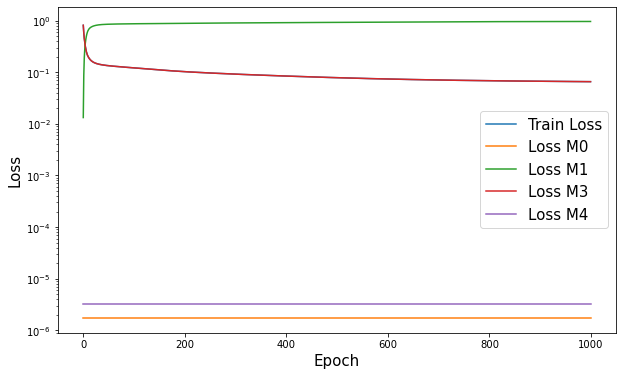

In [35]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label = "Train Loss")
plt.plot(LOSS_m0, label = "Loss M0")
plt.plot(LOSS_m1, label = "Loss M1")
#plt.plot(LOSS_m2, label = "Loss M2")
plt.plot(LOSS_m3, label = "Loss M3")
plt.plot(LOSS_m4, label = "Loss M4")
plt.ylabel("Loss", fontsize=15)
plt.xlabel("Epoch", fontsize=15)
plt.yscale("log")
plt.legend(fontsize=15)
plt.show()

# Rollout Evaluation After FineTuning

In [36]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 0.0030799021
RMSE of after m1 0.008104489
RMSE of after m3 2.6874785
RMSE of after m4 2.2592816
RMSE of after m0 0.005100274
RMSE of after m1 0.059873275
RMSE of after m3 4.5517917
RMSE of after m4 4.085817
RMSE of after m0 0.009541356
RMSE of after m1 0.04318201
RMSE of after m3 5.7058253
RMSE of after m4 5.0333743
RMSE of after m0 0.009100303
RMSE of after m1 0.024769811
RMSE of after m3 5.869534
RMSE of after m4 5.133299
RMSE of after m0 0.004205171
RMSE of after m1 0.014499267
RMSE of after m3 5.689877
RMSE of after m4 4.955582
RMSE of after m0 0.0039011783
RMSE of after m1 0.009346464
RMSE of after m3 5.561022
RMSE of after m4 4.835682
RMSE of after m0 0.0041680806
RMSE of after m1 0.008660984
RMSE of after m3 5.4676127
RMSE of after m4 4.756882
RMSE of after m0 0.003965744
RMSE of after m1 0.0075163143
RMSE of after m3 5.450552
RMSE of after m4 4.7367024
RMSE of after m0 0.0038930282
RMSE of after m1 0.008013286
RMSE of after m3 5.4378176
RMSE of after m4 4.72534

RMSE of after m4 2.7092347
RMSE of after m0 0.00494
RMSE of after m1 0.005027996
RMSE of after m3 3.066223
RMSE of after m4 2.7700605
RMSE of after m0 0.00230312
RMSE of after m1 0.0050695585
RMSE of after m3 3.0888052
RMSE of after m4 2.7862942
RMSE of after m0 0.0025579957
RMSE of after m1 0.006263961
RMSE of after m3 3.0136123
RMSE of after m4 2.6998615
RMSE of after m0 0.0032259836
RMSE of after m1 0.013047637
RMSE of after m3 2.8884919
RMSE of after m4 2.587527
RMSE of after m0 0.0058569917
RMSE of after m1 0.012817422
RMSE of after m3 3.0644445
RMSE of after m4 2.7694871
RMSE of after m0 0.011964982
RMSE of after m1 0.007750531
RMSE of after m3 3.2751088
RMSE of after m4 2.9400306
RMSE of after m0 0.019009812
RMSE of after m1 0.008205236
RMSE of after m3 4.051367
RMSE of after m4 3.5589755
RMSE of after m0 0.0037635248
RMSE of after m1 0.014380135
RMSE of after m3 3.976016
RMSE of after m4 3.442771
RMSE of after m0 0.0040941415
RMSE of after m1 0.013866712
RMSE of after m3 3.8784

RMSE of after m4 3.8590043
RMSE of after m0 0.008186525
RMSE of after m1 0.008566889
RMSE of after m3 4.0055914
RMSE of after m4 4.052113
RMSE of after m0 0.0066033597
RMSE of after m1 0.0068184715
RMSE of after m3 4.0650525
RMSE of after m4 4.1345
RMSE of after m0 0.008624438
RMSE of after m1 0.008584195
RMSE of after m3 4.1970897
RMSE of after m4 4.3228064
RMSE of after m0 0.007727352
RMSE of after m1 0.007626879
RMSE of after m3 4.436574
RMSE of after m4 4.6442847
RMSE of after m0 0.004811083
RMSE of after m1 0.005184207
RMSE of after m3 4.5536704
RMSE of after m4 4.823317
RMSE of after m0 0.005331573
RMSE of after m1 0.005474627
RMSE of after m3 4.537858
RMSE of after m4 4.8063784
RMSE of after m0 0.004085283
RMSE of after m1 0.0043576523
RMSE of after m3 4.43944
RMSE of after m4 4.6986623
RMSE of after m0 0.004307863
RMSE of after m1 0.004428787
RMSE of after m3 4.5015225
RMSE of after m4 4.770098
RMSE of after m0 0.005771909
RMSE of after m1 0.0058984165
RMSE of after m3 4.574127

RMSE of after m4 6.00784
RMSE of after m0 0.0065904227
RMSE of after m1 0.0073090256
RMSE of after m3 5.6623297
RMSE of after m4 5.969666
RMSE of after m0 0.0072110435
RMSE of after m1 0.0076290662
RMSE of after m3 5.789521
RMSE of after m4 6.128615
RMSE of after m0 0.0061523765
RMSE of after m1 0.0067923223
RMSE of after m3 5.792497
RMSE of after m4 6.1108017
RMSE of after m0 0.005796516
RMSE of after m1 0.0066482336
RMSE of after m3 5.6687636
RMSE of after m4 5.942321
RMSE of after m0 0.005907379
RMSE of after m1 0.006823114
RMSE of after m3 5.620909
RMSE of after m4 5.8762293
RMSE of after m0 0.005264641
RMSE of after m1 0.006235201
RMSE of after m3 5.597678
RMSE of after m4 5.8523903
RMSE of after m0 0.00758357
RMSE of after m1 0.008231682
RMSE of after m3 5.3966665
RMSE of after m4 5.605758
RMSE of after m0 0.00499292
RMSE of after m1 0.00585626
RMSE of after m3 5.3745174
RMSE of after m4 5.5662737
RMSE of after m0 0.006886166
RMSE of after m1 0.007751992
RMSE of after m3 5.342548

RMSE of after m1 0.01118804
RMSE of after m3 9.002008
RMSE of after m4 7.503647
RMSE of after m0 0.0028294036
RMSE of after m1 0.0098397825
RMSE of after m3 8.942434
RMSE of after m4 7.4619865
RMSE of after m0 0.0020408214
RMSE of after m1 0.008827376
RMSE of after m3 8.891727
RMSE of after m4 7.4392443
RMSE of after m0 0.0023620324
RMSE of after m1 0.009644253
RMSE of after m3 8.7391815
RMSE of after m4 7.3328576
RMSE of after m0 0.0022511291
RMSE of after m1 0.01597624
RMSE of after m3 8.513177
RMSE of after m4 7.187526
RMSE of after m0 0.0026805645
RMSE of after m1 0.014578105
RMSE of after m3 8.347139
RMSE of after m4 7.0346594
RMSE of after m0 0.0029930596
RMSE of after m1 0.012897798
RMSE of after m3 8.165685
RMSE of after m4 6.901668
RMSE of after m0 0.0033847443
RMSE of after m1 0.007634439
RMSE of after m3 8.317099
RMSE of after m4 6.988645
RMSE of after m0 0.0027664944
RMSE of after m1 0.011082902
RMSE of after m3 8.13142
RMSE of after m4 6.8721786
RMSE of after m0 0.00372651

RMSE of after m1 0.008658389
RMSE of after m3 1.2192395
RMSE of after m4 1.1048423
RMSE of after m0 0.004905067
RMSE of after m1 0.0063090613
RMSE of after m3 1.2204732
RMSE of after m4 1.0988071
RMSE of after m0 0.0053028343
RMSE of after m1 0.0064038443
RMSE of after m3 1.2473568
RMSE of after m4 1.1182027
RMSE of after m0 0.0049236603
RMSE of after m1 0.007827435
RMSE of after m3 1.2926205
RMSE of after m4 1.1555877
RMSE of after m0 0.005728681
RMSE of after m1 0.005215956
RMSE of after m3 1.2332994
RMSE of after m4 1.1117841
RMSE of after m0 0.006030768
RMSE of after m1 0.007430628
RMSE of after m3 1.2243218
RMSE of after m4 1.1190345
RMSE of after m0 0.006790986
RMSE of after m1 0.006402461
RMSE of after m3 1.2166896
RMSE of after m4 1.119596
RMSE of after m0 0.0053957193
RMSE of after m1 0.004875423
RMSE of after m3 1.13729
RMSE of after m4 1.0539683
RMSE of after m0 0.006340277
RMSE of after m1 0.006500483
RMSE of after m3 0.98873526
RMSE of after m4 0.95107836
RMSE of after m0 

RMSE of after m1 0.005384258
RMSE of after m3 2.7800174
RMSE of after m4 2.2332854
RMSE of after m0 0.0038434435
RMSE of after m1 0.0041537457
RMSE of after m3 3.2480195
RMSE of after m4 2.4968457
RMSE of after m0 0.003740491
RMSE of after m1 0.0041909963
RMSE of after m3 3.0498037
RMSE of after m4 2.3851006
RMSE of after m0 0.003761135
RMSE of after m1 0.0042461623
RMSE of after m3 3.3107207
RMSE of after m4 2.5325732
RMSE of after m0 0.0081965355
RMSE of after m1 0.0061631007
RMSE of after m3 3.5062432
RMSE of after m4 2.6246338
RMSE of after m0 0.011319596
RMSE of after m1 0.0075496244
RMSE of after m3 3.4993963
RMSE of after m4 2.6116865
RMSE of after m0 0.005144508
RMSE of after m1 0.008196461
RMSE of after m3 3.3319511
RMSE of after m4 2.5253823
RMSE of after m0 0.005237053
RMSE of after m1 0.010277388
RMSE of after m3 3.2854095
RMSE of after m4 2.4980574
RMSE of after m0 0.007023051
RMSE of after m1 0.0047999215
RMSE of after m3 3.5329957
RMSE of after m4 2.6512232
RMSE of after

RMSE of after m1 0.0072532846
RMSE of after m3 4.417564
RMSE of after m4 4.720814
RMSE of after m0 0.0061426247
RMSE of after m1 0.0071638315
RMSE of after m3 4.3623924
RMSE of after m4 4.6503577
RMSE of after m0 0.004600166
RMSE of after m1 0.0057665715
RMSE of after m3 4.380281
RMSE of after m4 4.664031
RMSE of after m0 0.0039154766
RMSE of after m1 0.005517809
RMSE of after m3 4.3492255
RMSE of after m4 4.6299047
RMSE of after m0 0.006640875
RMSE of after m1 0.007831412
RMSE of after m3 4.3983293
RMSE of after m4 4.6958427
RMSE of after m0 0.007831473
RMSE of after m1 0.008407655
RMSE of after m3 4.478647
RMSE of after m4 4.765458
RMSE of after m0 0.0056756623
RMSE of after m1 0.0064234384
RMSE of after m3 4.545728
RMSE of after m4 4.8466306
RMSE of after m0 0.005451498
RMSE of after m1 0.0061273323
RMSE of after m3 4.6831956
RMSE of after m4 5.0234146
RMSE of after m0 0.0063393144
RMSE of after m1 0.006863122
RMSE of after m3 4.746346
RMSE of after m4 5.111164
RMSE of after m0 0.00

RMSE of after m1 0.0057199234
RMSE of after m3 5.0785084
RMSE of after m4 5.1983724
RMSE of after m0 0.0037700336
RMSE of after m1 0.004901149
RMSE of after m3 5.0294156
RMSE of after m4 5.1358614
RMSE of after m0 0.008446439
RMSE of after m1 0.009661776
RMSE of after m3 5.183423
RMSE of after m4 5.303553
RMSE of after m0 0.01143506
RMSE of after m1 0.011780415
RMSE of after m3 5.578351
RMSE of after m4 5.8757124
RMSE of after m0 0.010646553
RMSE of after m1 0.01072221
RMSE of after m3 5.817013
RMSE of after m4 6.1978755
RMSE of after m0 0.0050805984
RMSE of after m1 0.0054688337
RMSE of after m3 6.0159044
RMSE of after m4 6.457743
RMSE of after m0 0.004234015
RMSE of after m1 0.004807804
RMSE of after m3 5.9866676
RMSE of after m4 6.434389
RMSE of after m0 0.0048769857
RMSE of after m1 0.0049301293
RMSE of after m3 6.0142074
RMSE of after m4 6.426704
RMSE of after m0 0.0077994084
RMSE of after m1 0.0077583827
RMSE of after m3 6.186715
RMSE of after m4 6.62583
RMSE of after m0 0.005921

RMSE of after m0 0.0059339274
RMSE of after m1 0.009010795
RMSE of after m3 6.0132346
RMSE of after m4 5.1523094
RMSE of after m0 0.0064484864
RMSE of after m1 0.007090678
RMSE of after m3 5.655631
RMSE of after m4 4.874471
RMSE of after m0 0.0026352326
RMSE of after m1 0.0038812815
RMSE of after m3 5.451255
RMSE of after m4 4.729651
RMSE of after m0 0.0058360477
RMSE of after m1 0.004679418
RMSE of after m3 5.3471
RMSE of after m4 4.6463513
RMSE of after m0 0.0039025587
RMSE of after m1 0.0050231935
RMSE of after m3 5.444867
RMSE of after m4 4.7179556
RMSE of after m0 0.0033891553
RMSE of after m1 0.004235846
RMSE of after m3 5.452654
RMSE of after m4 4.727149
RMSE of after m0 0.0030841553
RMSE of after m1 0.007048499
RMSE of after m3 5.478586
RMSE of after m4 4.7471848
RMSE of after m0 0.0028277456
RMSE of after m1 0.0064631747
RMSE of after m3 5.373483
RMSE of after m4 4.658492
RMSE of after m0 0.0018542579
RMSE of after m1 0.005509398
RMSE of after m3 5.347246
RMSE of after m4 4.63

RMSE of after m1 0.005866608
RMSE of after m3 0.9856331
RMSE of after m4 0.9966396
RMSE of after m0 0.005958503
RMSE of after m1 0.0072090407
RMSE of after m3 0.9824248
RMSE of after m4 0.99373364
RMSE of after m0 0.0050521754
RMSE of after m1 0.0052173627
RMSE of after m3 1.0125421
RMSE of after m4 1.0230287
RMSE of after m0 0.0033805864
RMSE of after m1 0.004800534
RMSE of after m3 0.9956064
RMSE of after m4 1.0016205
RMSE of after m0 0.006356705
RMSE of after m1 0.0062633054
RMSE of after m3 0.95805264
RMSE of after m4 0.9618272
RMSE of after m0 0.0062722545
RMSE of after m1 0.007489426
RMSE of after m3 0.9929781
RMSE of after m4 0.99840444
RMSE of after m0 0.006017802
RMSE of after m1 0.007880066
RMSE of after m3 1.0016739
RMSE of after m4 1.0073261
RMSE of after m0 0.004970284
RMSE of after m1 0.0052272226
RMSE of after m3 0.97397923
RMSE of after m4 0.98078513
RMSE of after m0 0.0032623156
RMSE of after m1 0.004623052
RMSE of after m3 0.92533624
RMSE of after m4 0.9256861
RMSE of

RMSE of after m1 0.0153081
RMSE of after m3 4.149668
RMSE of after m4 2.9201543
RMSE of after m0 0.0067407726
RMSE of after m1 0.0074367933
RMSE of after m3 4.279061
RMSE of after m4 2.9853437
RMSE of after m0 0.008194155
RMSE of after m1 0.009742464
RMSE of after m3 4.156988
RMSE of after m4 2.906879
RMSE of after m0 0.014078432
RMSE of after m1 0.012779389
RMSE of after m3 4.4342546
RMSE of after m4 3.039373
RMSE of after m0 0.006248399
RMSE of after m1 0.014694207
RMSE of after m3 4.8266397
RMSE of after m4 3.2174518
RMSE of after m0 0.0066794683
RMSE of after m1 0.014938251
RMSE of after m3 5.5486193
RMSE of after m4 3.5120277
RMSE of after m0 0.0115041835
RMSE of after m1 0.010616243
RMSE of after m3 5.7394905
RMSE of after m4 3.5929542
RMSE of after m0 0.007925514
RMSE of after m1 0.016680071
RMSE of after m3 5.9987574
RMSE of after m4 3.66901
RMSE of after m0 0.0090466775
RMSE of after m1 0.015567482
RMSE of after m3 5.564632
RMSE of after m4 4.8922815
RMSE of after m0 0.0063365

RMSE of after m1 0.006872145
RMSE of after m3 5.1779423
RMSE of after m4 5.69962
RMSE of after m0 0.005940549
RMSE of after m1 0.0058523538
RMSE of after m3 5.65744
RMSE of after m4 6.317439
RMSE of after m0 0.013545333
RMSE of after m1 0.013448087
RMSE of after m3 5.64169
RMSE of after m4 6.2851853
RMSE of after m0 0.0044469167
RMSE of after m1 0.0050216983
RMSE of after m3 5.572975
RMSE of after m4 6.1734495
RMSE of after m0 0.0065351627
RMSE of after m1 0.007131426
RMSE of after m3 5.6556263
RMSE of after m4 6.26114
RMSE of after m0 0.0062548993
RMSE of after m1 0.006872792
RMSE of after m3 5.7519827
RMSE of after m4 6.3855233
RMSE of after m0 0.0038504994
RMSE of after m1 0.004536742
RMSE of after m3 5.5641885
RMSE of after m4 6.187208
RMSE of after m0 0.0052574403
RMSE of after m1 0.005656747
RMSE of after m3 5.69279
RMSE of after m4 6.3168874
RMSE of after m0 0.004976989
RMSE of after m1 0.0053551868
RMSE of after m3 5.925098
RMSE of after m4 6.6200233
RMSE of after m0 0.00616889

RMSE of after m0 0.0063004135
RMSE of after m1 0.0064841313
RMSE of after m3 7.0605903
RMSE of after m4 7.7078195
RMSE of after m0 0.006419562
RMSE of after m1 0.006904353
RMSE of after m3 7.0502563
RMSE of after m4 7.6841183
RMSE of after m0 0.003948887
RMSE of after m1 0.0044785375
RMSE of after m3 6.912769
RMSE of after m4 7.534332
RMSE of after m0 0.004917965
RMSE of after m1 0.005336111
RMSE of after m3 6.8319693
RMSE of after m4 7.466511
RMSE of after m0 0.0073606134
RMSE of after m1 0.0073732743
RMSE of after m3 6.9639473
RMSE of after m4 7.603812
RMSE of after m0 0.007879094
RMSE of after m1 0.007861203
RMSE of after m3 6.654981
RMSE of after m4 7.2516565
RMSE of after m0 0.0069209705
RMSE of after m1 0.006574794
RMSE of after m3 6.646573
RMSE of after m4 7.212546
RMSE of after m0 0.0090779215
RMSE of after m1 0.008921519
RMSE of after m3 6.668633
RMSE of after m4 7.2689166
RMSE of after m0 0.006141989
RMSE of after m1 0.006192861
RMSE of after m3 6.7234488
RMSE of after m4 7.3

RMSE of after m3 7.99254
RMSE of after m4 6.557437
RMSE of after m0 0.005282278
RMSE of after m1 0.0035890376
RMSE of after m3 7.250409
RMSE of after m4 6.022647
RMSE of after m0 0.003797955
RMSE of after m1 0.0053437497
RMSE of after m3 6.477697
RMSE of after m4 5.495839
RMSE of after m0 0.0037455398
RMSE of after m1 0.0038690593
RMSE of after m3 6.5200696
RMSE of after m4 5.53097
RMSE of after m0 0.0032812778
RMSE of after m1 0.006461279
RMSE of after m3 6.480071
RMSE of after m4 5.5034018
RMSE of after m0 0.0057638474
RMSE of after m1 0.0052329004
RMSE of after m3 6.5540066
RMSE of after m4 5.5576806
RMSE of after m0 0.0036825463
RMSE of after m1 0.0051521524
RMSE of after m3 6.682407
RMSE of after m4 5.657733
RMSE of after m0 0.0025043879
RMSE of after m1 0.005793072
RMSE of after m3 6.637371
RMSE of after m4 5.613051
RMSE of after m0 0.0021995404
RMSE of after m1 0.005085018
RMSE of after m3 6.5241857
RMSE of after m4 5.5256796
RMSE of after m0 0.006789025
RMSE of after m1 0.00465

RMSE of after m1 0.0037944787
RMSE of after m3 1.0306535
RMSE of after m4 1.0257928
RMSE of after m0 0.0036738627
RMSE of after m1 0.005573252
RMSE of after m3 1.0500325
RMSE of after m4 1.0463067
RMSE of after m0 0.003607695
RMSE of after m1 0.0031486098
RMSE of after m3 1.0065275
RMSE of after m4 1.006428
RMSE of after m0 0.004035822
RMSE of after m1 0.0056284205
RMSE of after m3 1.050854
RMSE of after m4 1.0523518
RMSE of after m0 0.003732741
RMSE of after m1 0.0066381563
RMSE of after m3 0.94118255
RMSE of after m4 0.93447495
RMSE of after m0 0.003968494
RMSE of after m1 0.004882991
RMSE of after m3 0.9351597
RMSE of after m4 0.9316521
RMSE of after m0 0.0046408935
RMSE of after m1 0.0045147315
RMSE of after m3 0.9660698
RMSE of after m4 0.9688514
RMSE of after m0 0.0034298687
RMSE of after m1 0.0049069123
RMSE of after m3 0.9456105
RMSE of after m4 0.9428855
RMSE of after m0 0.0039572692
RMSE of after m1 0.0075116153
RMSE of after m3 0.9083964
RMSE of after m4 0.90626514
RMSE of a

RMSE of after m3 2.96823
RMSE of after m4 2.3557034
RMSE of after m0 0.00875053
RMSE of after m1 0.01533354
RMSE of after m3 2.934434
RMSE of after m4 2.340919
RMSE of after m0 0.0074348943
RMSE of after m1 0.0074723638
RMSE of after m3 3.482357
RMSE of after m4 2.697409
RMSE of after m0 0.007286893
RMSE of after m1 0.012877224
RMSE of after m3 3.1741765
RMSE of after m4 2.4680774
RMSE of after m0 0.007708127
RMSE of after m1 0.009674764
RMSE of after m3 3.2279642
RMSE of after m4 2.4946806
RMSE of after m0 0.008629963
RMSE of after m1 0.009473454
RMSE of after m3 3.5755417
RMSE of after m4 2.6746109
RMSE of after m0 0.006884027
RMSE of after m1 0.009564122
RMSE of after m3 3.627539
RMSE of after m4 2.7213938
RMSE of after m0 0.007012825
RMSE of after m1 0.014799655
RMSE of after m3 3.7001343
RMSE of after m4 2.7541628
RMSE of after m0 0.016758164
RMSE of after m1 0.015814956
RMSE of after m3 4.3777256
RMSE of after m4 3.1234229
RMSE of after m0 0.0130802095
RMSE of after m1 0.01843469

RMSE of after m1 0.0059185764
RMSE of after m3 4.837622
RMSE of after m4 5.1560807
RMSE of after m0 0.0047569117
RMSE of after m1 0.0048672804
RMSE of after m3 4.7875905
RMSE of after m4 5.1075845
RMSE of after m0 0.005498245
RMSE of after m1 0.0056555057
RMSE of after m3 4.674128
RMSE of after m4 4.9830556
RMSE of after m0 0.0054199253
RMSE of after m1 0.0055165654
RMSE of after m3 4.771855
RMSE of after m4 5.0771995
RMSE of after m0 0.006418692
RMSE of after m1 0.006811597
RMSE of after m3 4.810229
RMSE of after m4 5.117848
RMSE of after m0 0.0061023827
RMSE of after m1 0.006525178
RMSE of after m3 4.7315626
RMSE of after m4 5.0523977
RMSE of after m0 0.0056103254
RMSE of after m1 0.0055834046
RMSE of after m3 4.851448
RMSE of after m4 5.1463246
RMSE of after m0 0.004495244
RMSE of after m1 0.00452549
RMSE of after m3 4.8118496
RMSE of after m4 5.0787015
RMSE of after m0 0.007902727
RMSE of after m1 0.008350607
RMSE of after m3 4.817644
RMSE of after m4 5.0764194
RMSE of after m0 0.0

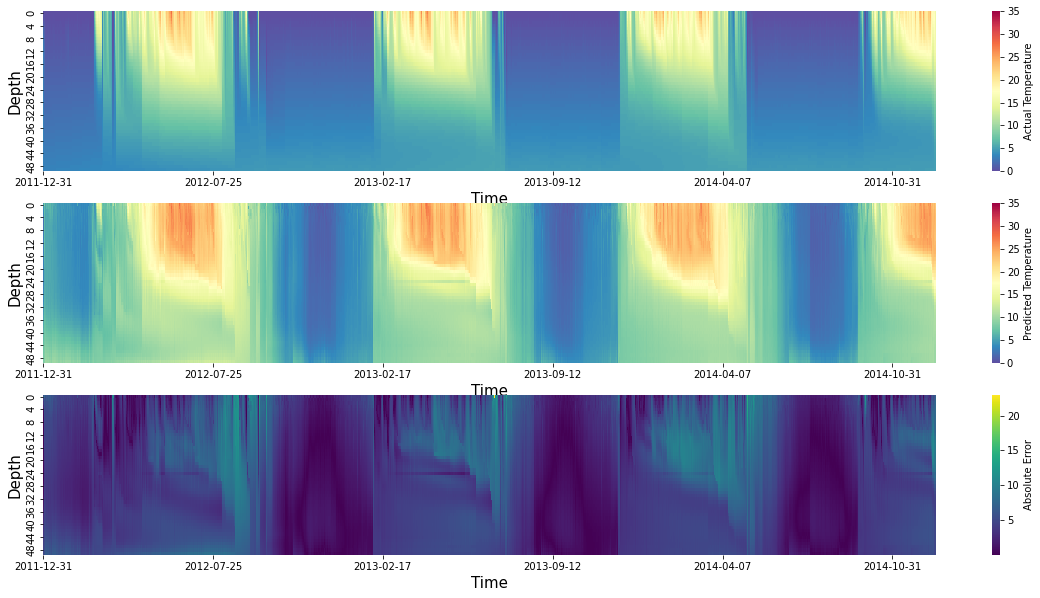

In [37]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

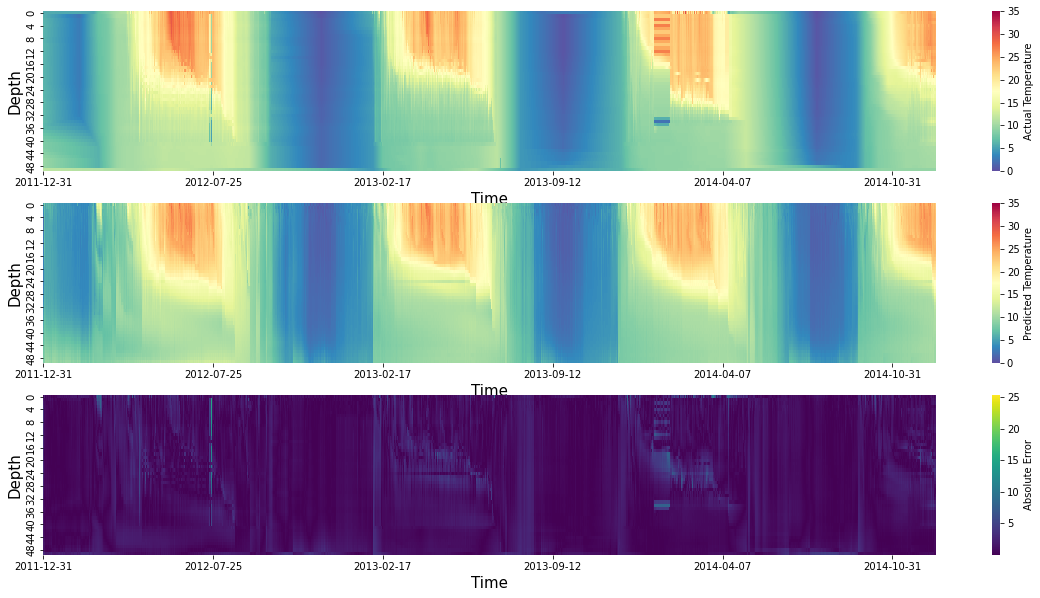

In [38]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

In [39]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.0035381785
RMSE of after m1 0.004089798
RMSE of after m3 6.145818
RMSE of after m4 6.7789254
RMSE of after m0 0.005730843
RMSE of after m1 0.0061053326
RMSE of after m3 6.209743
RMSE of after m4 6.825514
RMSE of after m0 0.0054727774
RMSE of after m1 0.0059588305
RMSE of after m3 5.981922
RMSE of after m4 6.5563006
RMSE of after m0 0.005438608
RMSE of after m1 0.0060272017
RMSE of after m3 5.961362
RMSE of after m4 6.5212846
RMSE of after m0 0.004458562
RMSE of after m1 0.005161021
RMSE of after m3 5.9373684
RMSE of after m4 6.4930816
RMSE of after m0 0.0053281644
RMSE of after m1 0.006173695
RMSE of after m3 5.96609
RMSE of after m4 6.5288606
RMSE of after m0 0.0057812664
RMSE of after m1 0.006340427
RMSE of after m3 5.9758124
RMSE of after m4 6.530539
RMSE of after m0 0.006371951
RMSE of after m1 0.006839065
RMSE of after m3 5.974355
RMSE of after m4 6.5173798
RMSE of after m0 0.0048214174
RMSE of after m1 0.005386999
RMSE of after m3 6.0621924
RMSE of after m4 6.6

RMSE of after m0 0.0074722343
RMSE of after m1 0.00825619
RMSE of after m3 7.0579596
RMSE of after m4 6.552155
RMSE of after m0 0.0076114945
RMSE of after m1 0.008792637
RMSE of after m3 6.7549047
RMSE of after m4 6.253521
RMSE of after m0 0.007023591
RMSE of after m1 0.008613633
RMSE of after m3 6.7133584
RMSE of after m4 6.249539
RMSE of after m0 0.0059318654
RMSE of after m1 0.007558088
RMSE of after m3 6.831895
RMSE of after m4 6.3695626
RMSE of after m0 0.0046965615
RMSE of after m1 0.0062368084
RMSE of after m3 6.844808
RMSE of after m4 6.4000354
RMSE of after m0 0.0046418663
RMSE of after m1 0.005761413
RMSE of after m3 6.551406
RMSE of after m4 6.0941978
RMSE of after m0 0.010152726
RMSE of after m1 0.010905536
RMSE of after m3 6.743643
RMSE of after m4 6.3225718
RMSE of after m0 0.0043081986
RMSE of after m1 0.008124846
RMSE of after m3 7.954354
RMSE of after m4 7.3956165
RMSE of after m0 0.002749876
RMSE of after m1 0.008039233
RMSE of after m3 7.9369407
RMSE of after m4 7.31

RMSE of after m1 0.026758377
RMSE of after m3 3.2243478
RMSE of after m4 2.98695
RMSE of after m0 0.0058530737
RMSE of after m1 0.024733271
RMSE of after m3 2.8221653
RMSE of after m4 2.6413918
RMSE of after m0 0.0101647675
RMSE of after m1 0.023265382
RMSE of after m3 3.034078
RMSE of after m4 2.8323138
RMSE of after m0 0.0070377043
RMSE of after m1 0.019769298
RMSE of after m3 2.7180285
RMSE of after m4 2.54334
RMSE of after m0 0.0036692284
RMSE of after m1 0.020934515
RMSE of after m3 2.6053498
RMSE of after m4 2.444615
RMSE of after m0 0.0022309322
RMSE of after m1 0.019489322
RMSE of after m3 2.5817392
RMSE of after m4 2.4228513
RMSE of after m0 0.0031312339
RMSE of after m1 0.021727659
RMSE of after m3 2.6535366
RMSE of after m4 2.4846177
RMSE of after m0 0.0075285095
RMSE of after m1 0.019929567
RMSE of after m3 2.6754613
RMSE of after m4 2.5144403
RMSE of after m0 0.010710261
RMSE of after m1 0.017999241
RMSE of after m3 2.699134
RMSE of after m4 2.53859
RMSE of after m0 0.0092

RMSE of after m0 0.005287308
RMSE of after m1 0.011187741
RMSE of after m3 4.731617
RMSE of after m4 4.4164157
RMSE of after m0 0.0071544996
RMSE of after m1 0.010576668
RMSE of after m3 4.413458
RMSE of after m4 4.1745367
RMSE of after m0 0.009200964
RMSE of after m1 0.012786866
RMSE of after m3 3.03169
RMSE of after m4 2.9074397
RMSE of after m0 0.004807601
RMSE of after m1 0.009280043
RMSE of after m3 3.0082712
RMSE of after m4 2.8761837
RMSE of after m0 0.0059056752
RMSE of after m1 0.011464145
RMSE of after m3 3.1647449
RMSE of after m4 3.0467818
RMSE of after m0 0.004899631
RMSE of after m1 0.013720842
RMSE of after m3 4.9805264
RMSE of after m4 4.6361713
RMSE of after m0 0.010577325
RMSE of after m1 0.108872525
RMSE of after m3 8.288601
RMSE of after m4 6.748735
RMSE of after m0 0.00981876
RMSE of after m1 0.013405562
RMSE of after m3 5.1632686
RMSE of after m4 4.518766
RMSE of after m0 0.0028566802
RMSE of after m1 0.014477896
RMSE of after m3 5.3906107
RMSE of after m4 4.70540

RMSE of after m1 0.005549807
RMSE of after m3 4.875874
RMSE of after m4 4.9398184
RMSE of after m0 0.009187284
RMSE of after m1 0.0096767
RMSE of after m3 4.8962994
RMSE of after m4 4.95352
RMSE of after m0 0.008770062
RMSE of after m1 0.009195313
RMSE of after m3 4.8961186
RMSE of after m4 4.957147
RMSE of after m0 0.004671913
RMSE of after m1 0.004687787
RMSE of after m3 4.880229
RMSE of after m4 4.9453588
RMSE of after m0 0.006997022
RMSE of after m1 0.007123214
RMSE of after m3 4.9177303
RMSE of after m4 4.975552
RMSE of after m0 0.00632791
RMSE of after m1 0.006638863
RMSE of after m3 4.9662466
RMSE of after m4 5.0440845
RMSE of after m0 0.0076796706
RMSE of after m1 0.007975505
RMSE of after m3 4.9776073
RMSE of after m4 5.0122943
RMSE of after m0 0.005912083
RMSE of after m1 0.006277225
RMSE of after m3 4.896881
RMSE of after m4 4.9419093
RMSE of after m0 0.0054397928
RMSE of after m1 0.005985405
RMSE of after m3 4.9738655
RMSE of after m4 5.028519
RMSE of after m0 0.005810675
R

RMSE of after m0 0.0038898236
RMSE of after m1 0.0049050036
RMSE of after m3 6.102784
RMSE of after m4 5.85187
RMSE of after m0 0.0068448703
RMSE of after m1 0.007945174
RMSE of after m3 6.1591935
RMSE of after m4 5.9170294
RMSE of after m0 0.0052973367
RMSE of after m1 0.006555467
RMSE of after m3 6.244673
RMSE of after m4 5.9980054
RMSE of after m0 0.003257995
RMSE of after m1 0.004450102
RMSE of after m3 6.0637603
RMSE of after m4 5.8115215
RMSE of after m0 0.0037564598
RMSE of after m1 0.0049749096
RMSE of after m3 6.052441
RMSE of after m4 5.775903
RMSE of after m0 0.0038529688
RMSE of after m1 0.005084962
RMSE of after m3 6.080902
RMSE of after m4 5.799157
RMSE of after m0 0.003869166
RMSE of after m1 0.004909535
RMSE of after m3 6.0917335
RMSE of after m4 5.7929688
RMSE of after m0 0.00871698
RMSE of after m1 0.009849025
RMSE of after m3 6.2403817
RMSE of after m4 5.9320593
RMSE of after m0 0.0056085787
RMSE of after m1 0.0069539375
RMSE of after m3 6.2960057
RMSE of after m4 6.

RMSE of after m4 4.463922
RMSE of after m0 0.0051380745
RMSE of after m1 0.006668162
RMSE of after m3 4.6643233
RMSE of after m4 4.427297
RMSE of after m0 0.0038981591
RMSE of after m1 0.0055946712
RMSE of after m3 4.5919724
RMSE of after m4 4.3419027
RMSE of after m0 0.004153959
RMSE of after m1 0.005857028
RMSE of after m3 4.469713
RMSE of after m4 4.24416
RMSE of after m0 0.0045921467
RMSE of after m1 0.0061148643
RMSE of after m3 4.4740148
RMSE of after m4 4.242442
RMSE of after m0 0.0038009733
RMSE of after m1 0.0054491227
RMSE of after m3 4.4243317
RMSE of after m4 4.190586
RMSE of after m0 0.007917583
RMSE of after m1 0.008797038
RMSE of after m3 4.5702267
RMSE of after m4 4.36298
RMSE of after m0 0.006964593
RMSE of after m1 0.0072736475
RMSE of after m3 4.819188
RMSE of after m4 4.654884
RMSE of after m0 0.0044754525
RMSE of after m1 0.0046714046
RMSE of after m3 5.013558
RMSE of after m4 4.8613505
RMSE of after m0 0.005795591
RMSE of after m1 0.0063427067
RMSE of after m3 4.9

RMSE of after m0 0.005432824
RMSE of after m1 0.012248287
RMSE of after m3 1.1075299
RMSE of after m4 1.090369
RMSE of after m0 0.004643437
RMSE of after m1 0.009368172
RMSE of after m3 1.0860525
RMSE of after m4 1.0686151
RMSE of after m0 0.0048918896
RMSE of after m1 0.010024478
RMSE of after m3 1.0914402
RMSE of after m4 1.0746857
RMSE of after m0 0.0049118605
RMSE of after m1 0.012513121
RMSE of after m3 1.0891696
RMSE of after m4 1.0733546
RMSE of after m0 0.0050542005
RMSE of after m1 0.0072849113
RMSE of after m3 1.137681
RMSE of after m4 1.1338967
RMSE of after m0 0.00384619
RMSE of after m1 0.008912296
RMSE of after m3 1.1800475
RMSE of after m4 1.1676328
RMSE of after m0 0.0031706584
RMSE of after m1 0.010338826
RMSE of after m3 1.1235437
RMSE of after m4 1.1115222
RMSE of after m0 0.0027186254
RMSE of after m1 0.0090052765
RMSE of after m3 1.1174723
RMSE of after m4 1.1062752
RMSE of after m0 0.002897556
RMSE of after m1 0.009325707
RMSE of after m3 1.1133327
RMSE of after m

RMSE of after m3 3.2055244
RMSE of after m4 3.1216156
RMSE of after m0 0.0043908902
RMSE of after m1 0.009015253
RMSE of after m3 2.9434142
RMSE of after m4 2.8555636
RMSE of after m0 0.0042735
RMSE of after m1 0.0077279033
RMSE of after m3 2.881233
RMSE of after m4 2.79375
RMSE of after m0 0.005466221
RMSE of after m1 0.010001507
RMSE of after m3 3.0453465
RMSE of after m4 2.9886763
RMSE of after m0 0.0053453115
RMSE of after m1 0.011159954
RMSE of after m3 3.6700783
RMSE of after m4 3.5743468
RMSE of after m0 0.0065673357
RMSE of after m1 0.011586132
RMSE of after m3 3.6528187
RMSE of after m4 3.5526419
RMSE of after m0 0.011331856
RMSE of after m1 0.012398609
RMSE of after m3 2.4106557
RMSE of after m4 2.3666584
RMSE of after m0 0.0115419
RMSE of after m1 0.012147311
RMSE of after m3 3.4477847
RMSE of after m4 2.3989654
RMSE of after m0 0.0071155624
RMSE of after m1 0.007877641
RMSE of after m3 4.5363746
RMSE of after m4 2.5459046
RMSE of after m0 0.008314928
RMSE of after m1 0.0086

RMSE of after m0 0.0057882015
RMSE of after m1 0.0063270517
RMSE of after m3 4.168852
RMSE of after m4 4.5246816
RMSE of after m0 0.0072808033
RMSE of after m1 0.007603772
RMSE of after m3 4.305329
RMSE of after m4 4.681697
RMSE of after m0 0.0065513467
RMSE of after m1 0.007042228
RMSE of after m3 4.1302915
RMSE of after m4 4.456816
RMSE of after m0 0.008884556
RMSE of after m1 0.009492802
RMSE of after m3 4.3483834
RMSE of after m4 4.728711
RMSE of after m0 0.007865972
RMSE of after m1 0.008597348
RMSE of after m3 4.5352616
RMSE of after m4 4.9936666
RMSE of after m0 0.0077435337
RMSE of after m1 0.008463126
RMSE of after m3 4.674724
RMSE of after m4 5.184363
RMSE of after m0 0.007186374
RMSE of after m1 0.0074972524
RMSE of after m3 4.9199266
RMSE of after m4 5.4879518
RMSE of after m0 0.0056429836
RMSE of after m1 0.0058862492
RMSE of after m3 5.109162
RMSE of after m4 5.725857
RMSE of after m0 0.005410715
RMSE of after m1 0.0056685265
RMSE of after m3 5.1448994
RMSE of after m4 5.

RMSE of after m3 6.403988
RMSE of after m4 7.1070337
RMSE of after m0 0.0039404132
RMSE of after m1 0.0040148166
RMSE of after m3 6.299576
RMSE of after m4 6.9765444
RMSE of after m0 0.006746531
RMSE of after m1 0.0065283817
RMSE of after m3 6.3986607
RMSE of after m4 7.0638433
RMSE of after m0 0.0068168896
RMSE of after m1 0.0067273187
RMSE of after m3 6.349572
RMSE of after m4 7.0079985
RMSE of after m0 0.0070601013
RMSE of after m1 0.0070017762
RMSE of after m3 6.3399816
RMSE of after m4 7.0010676
RMSE of after m0 0.0039372873
RMSE of after m1 0.0043120864
RMSE of after m3 6.2620554
RMSE of after m4 6.917969
RMSE of after m0 0.004225902
RMSE of after m1 0.004541282
RMSE of after m3 6.107445
RMSE of after m4 6.7479897
RMSE of after m0 0.004135481
RMSE of after m1 0.0042199465
RMSE of after m3 5.998395
RMSE of after m4 6.6103454
RMSE of after m0 0.005998179
RMSE of after m1 0.005824885
RMSE of after m3 5.9953976
RMSE of after m4 6.584107
RMSE of after m0 0.005352547
RMSE of after m1 0

RMSE of after m1 0.006297464
RMSE of after m3 5.734318
RMSE of after m4 4.9774127
RMSE of after m0 0.0028418228
RMSE of after m1 0.006274827
RMSE of after m3 5.643879
RMSE of after m4 4.9138036
RMSE of after m0 0.003970703
RMSE of after m1 0.007458707
RMSE of after m3 5.723188
RMSE of after m4 4.961268
RMSE of after m0 0.008070703
RMSE of after m1 0.010444063
RMSE of after m3 5.6296706
RMSE of after m4 4.917505
RMSE of after m0 0.00330986
RMSE of after m1 0.0077068773
RMSE of after m3 6.928967
RMSE of after m4 5.941297
RMSE of after m0 0.002556004
RMSE of after m1 0.036046002
RMSE of after m3 6.163842
RMSE of after m4 5.2789097
RMSE of after m0 0.0024332132
RMSE of after m1 0.009449996
RMSE of after m3 4.969525
RMSE of after m4 4.3877077
RMSE of after m0 0.002018629
RMSE of after m1 0.0064825523
RMSE of after m3 4.9915977
RMSE of after m4 4.409296
RMSE of after m0 0.001898787
RMSE of after m1 0.0074680382
RMSE of after m3 4.8464394
RMSE of after m4 4.296024
RMSE of after m0 0.002102135

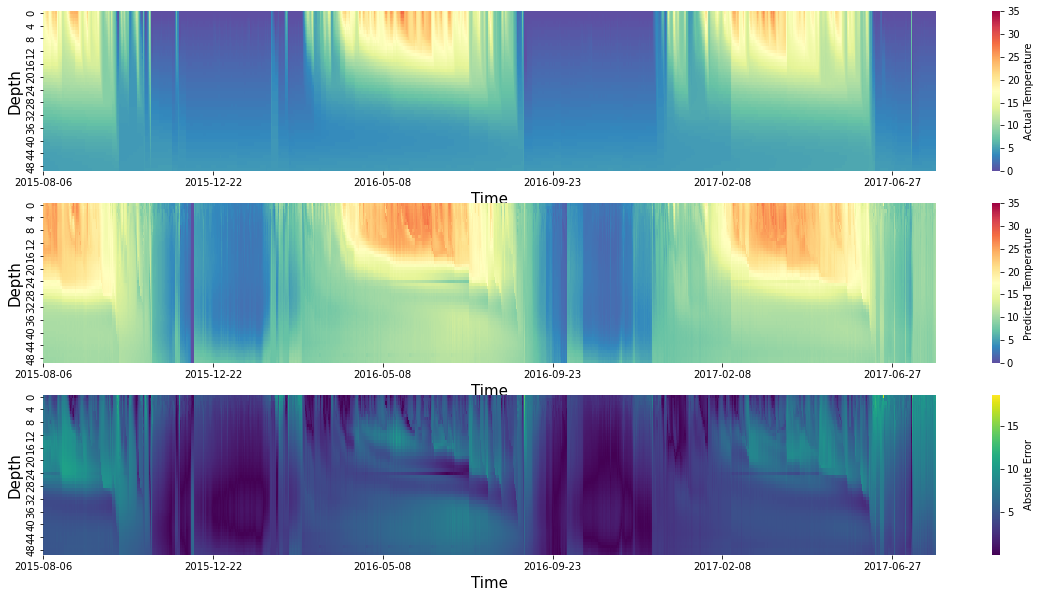

In [40]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

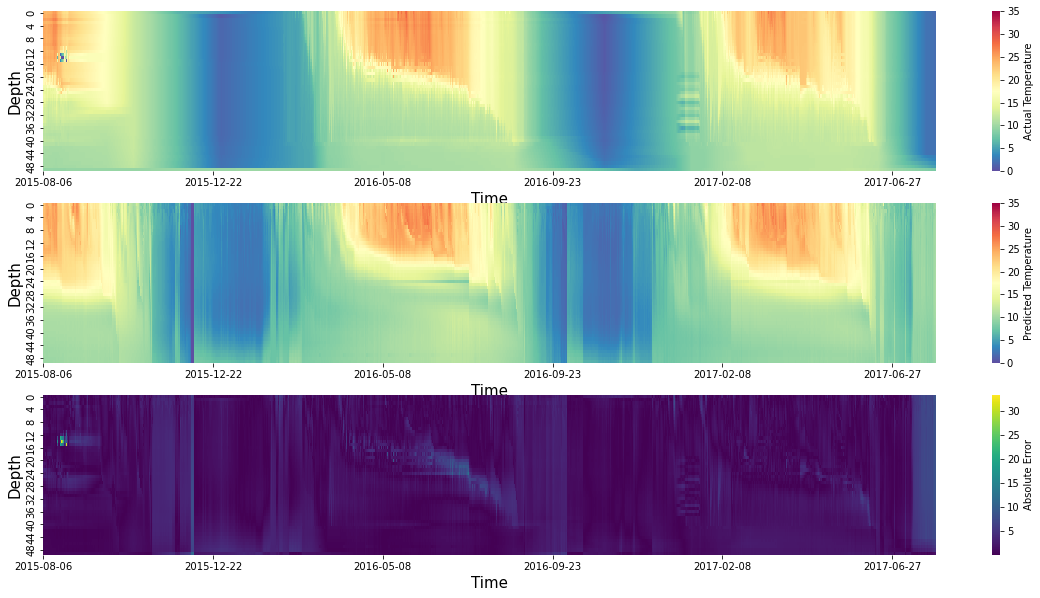

In [41]:
plot_output(test_y_pred, test_y_obs, depth_steps, test_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [42]:
train_rmse, train_l2_err = compute_metrics(heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 4.884100552247539, Train L2 Error: 0.6431608280817864
Test RMSE: 5.082273540855171, Train L2 Error: 0.6389157915553532


## Mixing Model

## Convection Model

In [43]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.014263324256871199, Train L2 Error: 0.001878372952570443
Test RMSE: 0.01547490462565185, Train L2 Error: 0.0019455367720686944


## Ice Model

In [44]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.0072898170040892425, Train L2 Error: 0.0009593164967734637
Test RMSE: 0.013696382045054916, Train L2 Error: 0.0017206306135897217


# Compute Model Similarity after Finetuning

In [45]:
def compute_model_similarity(model1, model2):
    weight1 = []
    weight2 = []
    for param1, param2 in zip(model1.parameters(), model2.parameters()):
        weight1.append(param1.detach().clone().flatten())
        weight2.append(param2.detach().clone().flatten())
    weight1 = torch.cat(weight1, dim=0)
    weight2 = torch.cat(weight2, dim=0)
    
    #Cosine Similarity
    cos = nn.CosineSimilarity(dim=0, eps=1e-8)
    cos_sim = cos(weight1, weight2)
    
    #L2 norm
    l2 = torch.norm((weight1-weight2), p='fro', dim=0)
    
    return cos_sim, l2

In [46]:
heating_model_init = MLP(m0_layers, activation="gelu")
heating_model_init.load_state_dict(m0_checkpoint)
heating_model_init = heating_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heating_model_init, heating_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [47]:
heat_diff_model_init = MLP(m1_layers, activation="gelu")
heat_diff_model_init.load_state_dict(m1_checkpoint)
heat_diff_model_init = heat_diff_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heat_diff_model_init, heat_diff_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 0.9076139330863953
L2 Norm: 7.278668403625488


In [48]:
convection_model_init = MLP(m3_layers, activation="gelu")
convection_model_init.load_state_dict(m3_checkpoint)
convection_model_init = convection_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(convection_model_init, convection_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [49]:
ice_model_init = MLP(m4_layers, activation="gelu")
ice_model_init.load_state_dict(m4_checkpoint)
ice_model_init = ice_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(ice_model_init, ice_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [50]:
# Freeze all models again and compute finetuned diffusivity values

In [51]:
# Unfreeze diffusion model and finetune it on projected diffusivities

In [52]:
PATH = f"./saved_models/diffusion_model_finetuned.pth"
torch.save(heat_diff_model.state_dict(), PATH)

In [53]:
def plot_output_freeLimits(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='Spectral_r')
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature")
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='Spectral_r')
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature")
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error")
    plt.show()

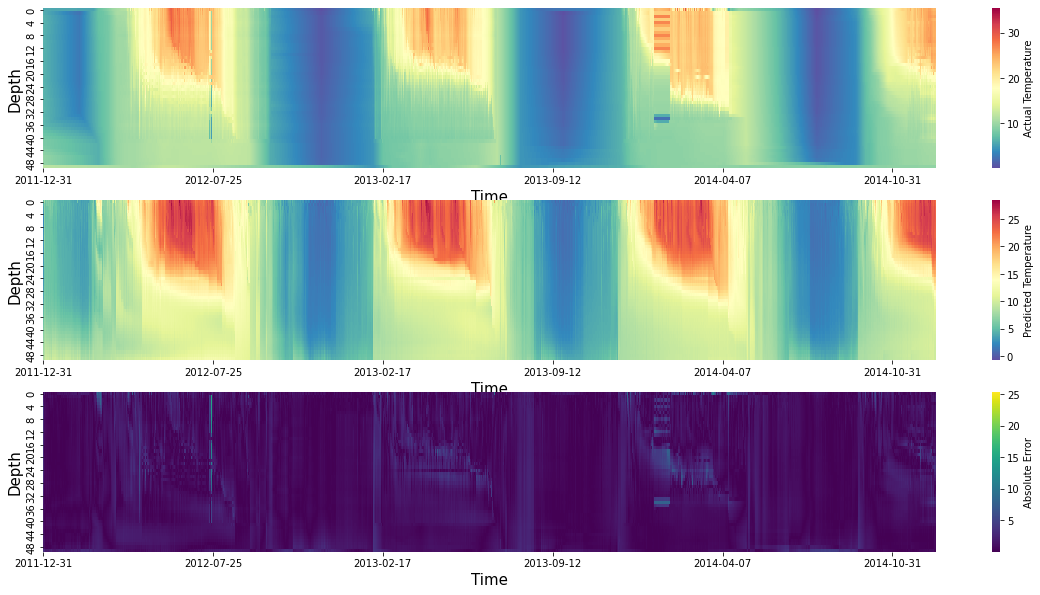

In [54]:
plot_output_freeLimits(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

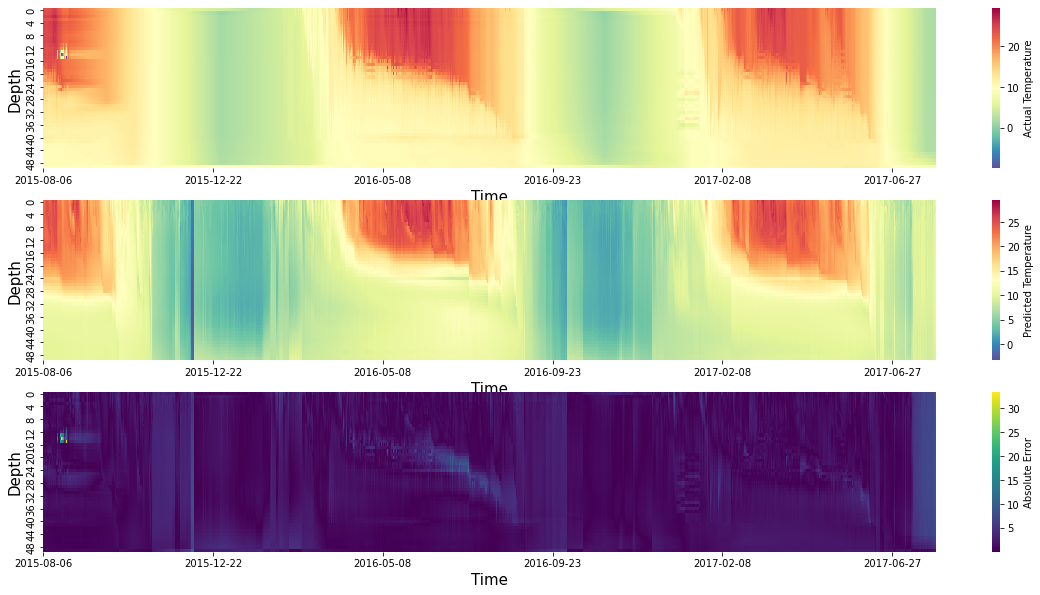

In [55]:
plot_output_freeLimits(test_y_pred, test_y_obs, depth_steps, test_time, figsize=(20,10))